In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_context("notebook")
sns.set_theme("notebook")
sns.set_style("whitegrid")
sns.set_palette("Dark2")

# Постановка задачи и загрузка данных

В рамках лабораторной работы поработаем снова с реальными данными, содержательно близкими к данным минус первой лабораторной, - про учебные дисциплины. В этот раз займемся обработкой и генерацией описания и содержания дисциплин с помощью языковых моделей.

## Данные

Расположены по ссылке.

In [2]:
!gdown 1k1drlKxdqLgw_y_iMgSkBuZwa2Gjc6Q1

Downloading...
From: https://drive.google.com/uc?id=1k1drlKxdqLgw_y_iMgSkBuZwa2Gjc6Q1
To: /content/disciplines_2018_2022.csv
100% 78.8M/78.8M [00:00<00:00, 143MB/s]


Из информации о дисциплине у нас есть следующая:
1. `course_id` - номер дисциплины (может повторяться)
2. `course_title` - название дисциплины
3. `description` - краткое описание дисциплины
4. `up_id` - айди учебного плана (образовательной прогарммы)
5. `up_title` - название учебного плана (образовательной прогарммы)
6. `qualification` - уровень образования (бакалавриат или магистратура)
7. `start_year` - год набора
8. `module_name` - название модуля, в который входит дисциплина
9. `contents` – содержание дисциплины (все темы и разделы не по порядку, сплошным текстом)

Данные уже частично предобработаны: датасет содержит только те дисциплины, которые реализовывались более одного года. Это примерно треть от всех дисциплин за 2018–2022 гг.

In [3]:
df = pd.read_csv("/content/disciplines_2018_2022.csv")
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....


In [4]:
df.shape

(20502, 9)

Немного погрузимся в данные.

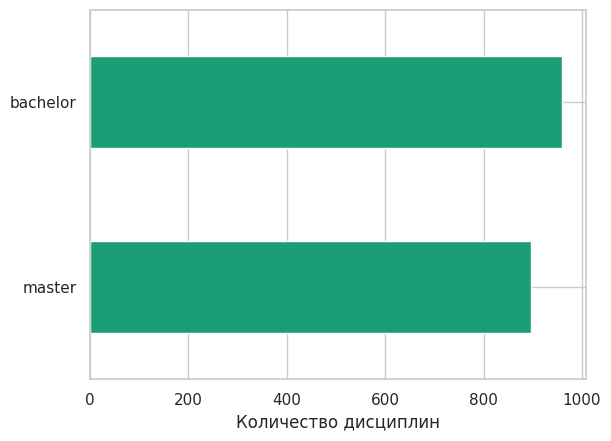

In [5]:
# количество дисциплин с уникальными названиями по уровням подготовки
df[["course_title", "qualification"]].drop_duplicates().qualification.value_counts().sort_values(ascending=True).plot(kind="barh")
plt.xlabel("Количество дисциплин")
plt.ylabel("")
plt.show()

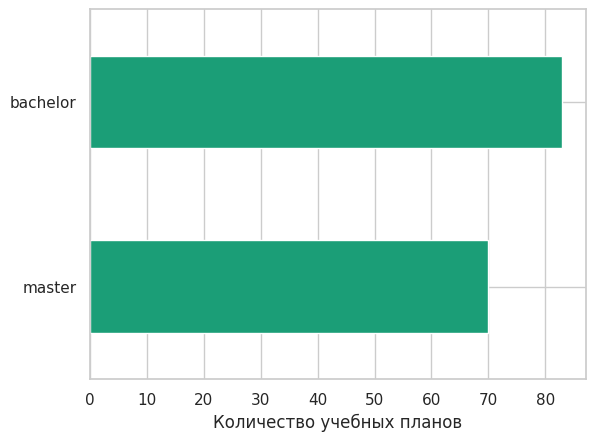

In [6]:
# количество учебных планов с уникальными названиями по уровням подготовки
df[["up_title", "qualification"]].drop_duplicates().qualification.value_counts().sort_values(ascending=True).plot(kind="barh")
plt.xlabel("Количество учебных планов")
plt.ylabel("")
plt.show()

Видим, что дисциплин больше (незначительно) в бакалавриате, но учебных планов больше в магистратуре. Это соответствует истине.

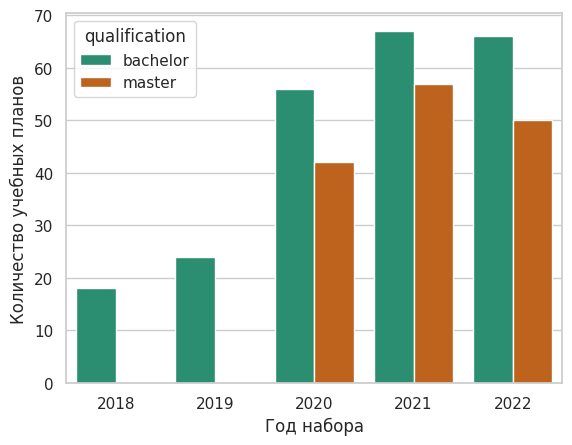

In [7]:
# количество учебных планов по годам и квалификациям
sns.barplot(data=df[["up_title", "qualification", "start_year"]].drop_duplicates().groupby(["start_year", "qualification"]).count().reset_index(), x="start_year", y="up_title", hue="qualification")
plt.ylabel("Количество учебных планов")
plt.xlabel("Год набора")
plt.show()

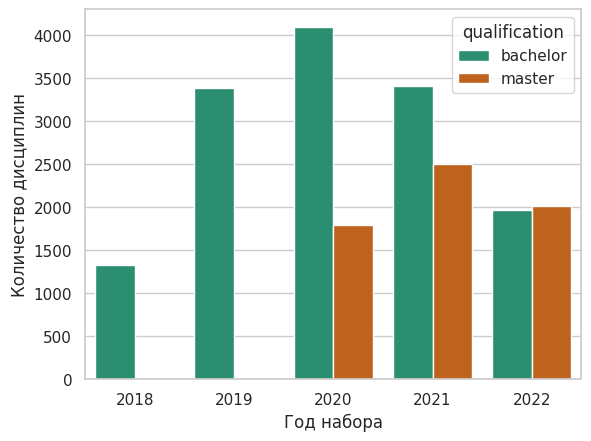

In [8]:
# количество дисциплин по годам и квалификациям
sns.barplot(data=df[["course_title", "qualification", "start_year"]].groupby(["start_year", "qualification"]).count().reset_index(), x="start_year", y="course_title", hue="qualification")
plt.ylabel("Количество дисциплин")
plt.xlabel("Год набора")
plt.show()

- Данные по магистратуре начали храниться с 2020 года, по бакалавриату – с 2018, поэтому графики выглядит именно так.
- Учебные планы могут существовать несколько лет с одним и тем же названием (как и дисциплины), поэтому в разрезе по годам уникальных записей больше, чем без него.

## Задача 1 – Предобработать description и contents
1. Выполнить предобработку текстовых данных. Минимально понадобятся следующие шаги предобработки:
  - приведение к одному регистру
  - токенизация
  - удаление пунктуации (можно оставить только буквенные символы в текстах)
  - лемматизация (можно использовать pymystem, он менее точный, чем pymorphy2, но работает в несколько раз быстрее)
2. Построить для дисциплины вектор на основе word2vec
3. Потестировать текстовые представления

Задач не много, но некоторые затратные по времени.

Для предобработки можно воспользовать материалами:
- https://colab.research.google.com/drive/1Lxe0_dPxF5_nNC1hnHTRc01rnMmUVCXa?usp=sharing
- https://colab.research.google.com/drive/16EFOsDbaTF2128kkVMqXxx2Xnb7Gr4mW?usp=share_link

### Предобработка текстовых данных

Проведите предобработку для столбца `contents`.

In [9]:
import nltk
from nltk.corpus import stopwords
import re
from pymystem3 import Mystem # для лемматизации
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

russian_stops = set(stopwords.words("russian"))
english_stops = set(stopwords.words("english"))
all_stops = russian_stops.union(english_stops)

m = Mystem()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [10]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zа-яё\s]", "", text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in all_stops]
    lemmas = [m.lemmatize(token)[0] for token in tokens]
    return lemmas



In [11]:
df['contents_processed'] = df['contents'].apply(preprocess_text)


In [12]:
# пример результата
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_processed
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг, корпоративный, фина..."
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят..."


Проведите предобработку для столбца `description`.

In [13]:
# обработка описания
df['description_processed'] = df['description'].apply(preprocess_text)

In [14]:
# пример результата
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_processed,description_processed
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг, корпоративный, фина...","[цель, курс, предоставлять, возможность, магис..."
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал...","[программа, составлять, соответствие, требован..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят...","[данный, дисциплина, учить, планировать, мероп..."


Данные минимально предобработаны. Можно переходить к векторизации. Рассмотрим два подхода:
- Word2Vec, обученный на предобработанных данных
- Tiny BERT – предобученная мини-версия мультиязычного BERT

### Кратко про языковые модели

Вне зависомости от того, большая модель или нет, данные, на которых она обучается и тестируется проходят одинаковые этапы предобработки.

Перед тем как начать обучение модели, необходимо подготовить текстовые данные. Этот процесс включает несколько этапов:

-	**Сбор данных.**

Модель обучается на большом корпусе текстов, который может включать книги, статьи, блоги, форумы и другие источники. Чем больше и разнообразнее данные, тем лучше модель сможет понять и воспроизвести язык.
-	**Токенизация.**

Процесс разбиения текста на отдельные элементы, называемые токенами. Токены могут представлять собой слова, части слов или даже отдельные символы. Например, фраза «Как дела?» может быть токенизирована как [«Как», «дела», «?»].
-	**Создание словарей.**

После токенизации формируется словарь, который сопоставляет с каждым токеном уникальный идентификатор. Этот словарь необходим для перевода текстовых данных в числовую форму, понятную модели.
-	**Преобразование текста в числовые векторы.**

Токены преобразуются в числовые векторы, которые будут использоваться в качестве входных данных для нейронной сети. Эти векторы могут быть статическими, как в Word2Vec, или динамическими, как в трансформерах.

---
Обучение языковой модели заключается в настройке её параметров на основе текстовых данных, чтобы она могла предсказывать следующее слово или генерировать осмысленные фразы.

-	**Forward propagation (прямой проход).**

На этом этапе данные проходят через слои нейронной сети, где каждое слово представляется в виде вектора. Эти векторы затем преобразуются в промежуточные состояния, которые несут информацию о контексте текста.
-	**Механизм внимания.**

В современных моделях, таких как трансформеры, используется механизм внимания, который позволяет модели выделять наиболее важные части текста, на которых нужно сосредоточиться при генерации или предсказании.
-	**Обратное распространение ошибки (Backpropagation).**

После того как модель сделала предсказание, она сравнивает его с реальными данными и вычисляет ошибку. Затем эта ошибка используется для корректировки параметров модели, чтобы улучшить точность предсказаний в будущем.
-	**Обучение на основе батчей.**

Данные разбиваются на небольшие группы — батчи, которые подаются модели для обучения. Этот метод позволяет эффективно использовать вычислительные ресурсы и ускорять процесс обучения.

Трансформеры
Современные языковые модели в большинстве основаны на архитектуре трансформеров, предложенной в 2017 году. Трансформеры решают многие проблемы, присущие RNN, и становятся доминирующим подходом в NLP.

-	**BERT (Bidirectional Encoder Representations from Transformers).**

Модель BERT использует двунаправленное обучение, что позволяет ей понимать контекст слова как слева, так и справа от него. Это делает BERT особенно мощным инструментом для задач, связанных с пониманием текста, таких как вопросо-ответные системы и анализ тональности.
-	**GPT (Generative Pre-Trained Transformer).**

Модель GPT, напротив, использует однонаправленное обучение, предсказывая следующее слово только на основе предыдущих слов. Эта модель, особенно в версиях GPT-2 и GPT-3, стала чрезвычайно популярной для генерации текста благодаря своей способности создавать связные и осмысленные сообщения, которые трудно отличить от текстов, написанных человеком.

### Векторизация word2vec

In [15]:
from gensim.models import Word2Vec
import gensim

In [16]:
# обучим на своих данных модель word2vec
# min_count – минимальная частота слова в корпусе
# vector_size – размер вектора для слова
# workers – количество потоков
# window – окно контекста, в которое попадает слово
tokens = df["contents_processed"] + df["contents_processed"]
w2v_model = Word2Vec(tokens, min_count=1, vector_size=300, workers=2, window=10)

In [17]:
w2v_model_path = "w2v.bin" # будет удобно сохранить модель, если выполняете лабу не за один вечер
w2v_model.save(w2v_model_path)

In [18]:
# загрузка сохраненной модели
w2v_model = gensim.models.Word2Vec.load(w2v_model_path)

In [19]:
# так выглядит один вектор
print(w2v_model.wv.get_vector("обучение").shape)  # размер вектора
w2v_model.wv.get_vector("обучение")

(300,)


array([ 1.9978551 ,  1.7506313 ,  4.102085  , -0.5831253 ,  3.2270477 ,
        0.2013384 ,  1.3479111 ,  0.7541693 , -3.4082267 , -2.9679477 ,
       -0.5252287 ,  0.4624742 ,  0.0105889 , -1.7282917 , -1.1058713 ,
       -3.0945704 ,  0.14532608, -1.624342  , -2.161701  ,  3.3984497 ,
       -2.5491192 ,  0.49056137,  3.082572  ,  0.24056968, -0.91412586,
       -4.458808  ,  1.726485  , -0.6171719 ,  3.0011635 ,  1.8019772 ,
        1.8610206 , -0.27804416,  0.935984  ,  2.94865   , -0.19222397,
        0.10211893,  2.8745556 , -1.1336457 ,  3.0191407 ,  0.42947474,
       -0.21113405,  4.9079175 , -0.34329033, -0.71104735, -2.4903886 ,
       -2.2343159 , -3.763184  ,  3.890428  , -1.7020105 ,  0.15037024,
        0.48927706, -2.8537707 ,  3.6099613 , -0.23438644, -0.4188665 ,
       -0.822664  ,  1.6567044 , -1.3688096 ,  0.3839663 ,  0.47543722,
       -0.18024014, -3.716722  ,  2.980434  , -1.9705888 ,  0.4159535 ,
       -0.19042997, -0.46822023,  0.22688733, -3.054273  ,  2.54

In [20]:
# слова, максимально близкие к "машинному обучению"
w2v_model.wv.most_similar(["обучение", "машинный"])

[('глубокий', 0.5779867172241211),
 ('байесовский', 0.5663905739784241),
 ('учитель', 0.5443094968795776),
 ('recall', 0.5183549523353577),
 ('предсказательный', 0.5096784830093384),
 ('подкрепление', 0.5028074383735657),
 ('нейросеть', 0.4983786344528198),
 ('дикторский', 0.4835957884788513),
 ('нейросетевой', 0.48352566361427307),
 ('аномалия', 0.4780038595199585)]

In [21]:
# слова, максимально близкие к "анализу данных"
w2v_model.wv.most_similar(["анализ", "данные"])

[('разметка', 0.4433157444000244),
 ('алгоритмизация', 0.43637707829475403),
 ('данный', 0.43215665221214294),
 ('троичный', 0.4195060729980469),
 ('wav', 0.4136064946651459),
 ('postagging', 0.4006306827068329),
 ('база', 0.3945562243461609),
 ('nosql', 0.3932912349700928),
 ('номинальный', 0.39290595054626465),
 ('статистика', 0.3917551636695862)]

Семантически получились не идеальные, но в целом близкие списки. Это естественно, т.к. уникальных записей для обучения было передано около 2000.

Создадим два вектора для каждой дисциплины:
1. По данным содержания (`contents`)
2. По данным описание дисциплины (`description`)

Учитывайте, что должна быть возможность построить эмбеддинг для нового текста, даже если некоторые слова отсутствуют в исходной модели. При этом вектор не должен быть нулевым. Для этого напишите функцию `embed()`, в качестве агрументов принимающую список токенов текста и модель.

Вектором текста должно являться среднее всех векторов слов текста.

In [22]:
def embed(tokens, w2v_model):
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]

    if len(vectors) == 0:
        return np.zeros(w2v_model.vector_size)
    return np.mean(vectors, axis=0)

# Пример вектора
embed(df.iloc[0].contents_processed, w2v_model)


array([-3.80824685e-01,  4.71801221e-01,  5.36240876e-01,  6.71666488e-02,
       -7.57829070e-01, -4.32471216e-01, -1.13751993e-01, -2.43704170e-01,
       -1.51007742e-01, -7.55510211e-01, -5.55685818e-01,  1.99130416e-01,
        3.94301742e-01,  5.74680984e-01,  7.27254927e-01, -1.13849914e+00,
       -2.16953889e-01, -8.87093306e-01, -1.85865775e-01, -2.15362906e-01,
       -6.62834764e-01, -5.68728626e-01,  4.59458530e-02, -4.68220741e-01,
       -9.23244298e-01,  1.06843144e-01, -4.16086540e-02, -3.38633448e-01,
       -7.52997458e-01, -9.65615928e-01, -1.35610163e-01,  3.48371387e-01,
       -2.39413694e-01,  8.83065522e-01, -2.27144986e-01, -2.84231484e-01,
       -4.78135377e-01, -4.41825151e-01,  1.86313152e-01, -1.88153759e-01,
        6.40932560e-01, -1.02139735e+00,  2.28828251e-01, -3.36672664e-01,
        4.53481704e-01,  4.07792270e-01, -4.12615329e-01, -5.90860426e-01,
       -3.07557255e-01, -3.68480176e-01,  7.82896727e-02, -5.94151914e-01,
        1.39528799e+00,  

Теперь применим функцию `embed()` для формирования вектора для содержаний и кратких описаний в каждой записи.

In [23]:
df['contents_embeddings'] = df['contents_processed'].apply(lambda tokens: embed(tokens, w2v_model))
df['description_embeddings'] = df['description_processed'].apply(lambda tokens: embed(tokens, w2v_model))

# пример результата
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_processed,description_processed,contents_embeddings,description_embeddings
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг, корпоративный, фина...","[цель, курс, предоставлять, возможность, магис...","[0.06767969, -0.28472564, 0.31307134, 0.699535...","[0.012876366, -0.3956631, 0.20657094, 0.846145..."
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал...","[программа, составлять, соответствие, требован...","[0.5080768, -0.027611058, -0.6020337, 0.176693...","[0.5496263, 0.19107383, 0.21620063, 0.9909335,..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят...","[данный, дисциплина, учить, планировать, мероп...","[-0.5510889, -0.13413431, 0.42117077, 0.477528...","[-0.27989793, -0.17410752, 0.2619099, 0.429120..."


Оценим, насколько семантически близки краткие описания дисциплин и темы в содержании. Для оценки воспользуемся косинусным сходством.

$$K(X, Y) = \frac{X \cdot Y} {||X||*||Y||}$$

В `sklearn` функция для расчета косинусного сходства генерирует матрицу результатов, мы будем сравнивать всего два вектора, поэтому напишем свою обертку для функции из `sklearn` так, чтобы она возвращала одно числовое значение, а не матрицу.

In [24]:
from sklearn.metrics.pairwise import cosine_similarity as cs

def cosine_similarity(vec1, vec2):
    cos_sim_res = cs([vec1], [vec2])[0,0]
    return cos_sim_res

In [25]:
# посчитаем косинусное сходство
df["desc_cont_sim"] = df.apply(lambda x: cosine_similarity(x["contents_embeddings"], x["description_embeddings"]), axis=1)

Оценим по графику распределение сходств для всех дисциплин. Должен получиться график, похожий на гистограмму ниже. Пунктиром обозначено медианное значение.

<ipython-input-26-18c1cc9bfaee>:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


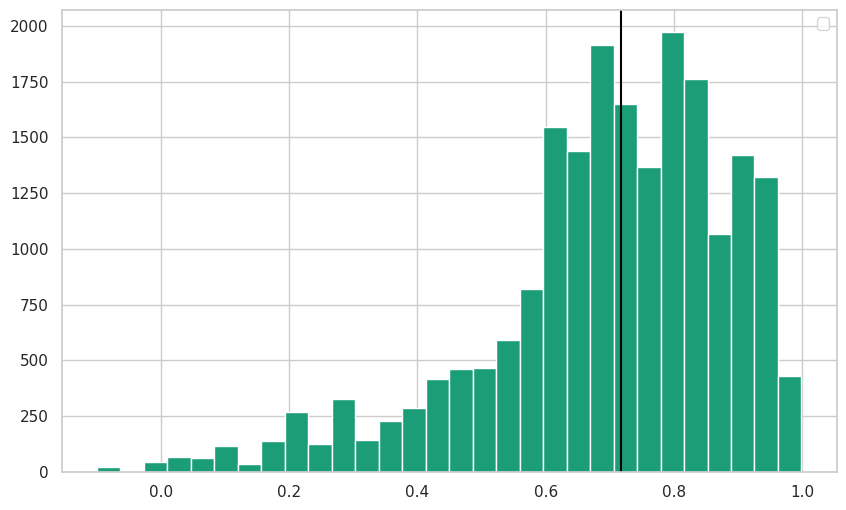

In [26]:
plt.figure(figsize=(10, 6))
plt.hist(df['desc_cont_sim'], bins=30)
plt.axvline(np.median(df['desc_cont_sim']), color ='black')
plt.legend()
plt.show()

### Векторизация Tiny BERT

В качестве предобученной модели воспользуемся Tiny BERT – https://huggingface.co/sergeyzh/rubert-tiny-turbo

Она априори менее точная, чем базовый BERT, но строит эмбеддинги в разы быстрее.

In [27]:
# загружаем модель из библиотеки huggingface

from sentence_transformers import SentenceTransformer

bert_model = SentenceTransformer('sergeyzh/rubert-tiny-turbo')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


> Если вы выполняете эту лабораторную локально, то возможны конфликты версии `sentence_transformers` и `tensorflow`, обычно решающиеся даунгрейдом `tensorflow`.

Прежде чем формировать эмбеддинги, объединим список токенов в строку.

In [28]:
df['contents_processed_text']=df['contents_processed'].apply(lambda x: ' '.join(x))
df['description_processed_text']=df['description_processed'].apply(lambda x: ' '.join(x))
# пример результата преобразования
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_processed,description_processed,contents_embeddings,description_embeddings,desc_cont_sim,contents_processed_text,description_processed_text
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг, корпоративный, фина...","[цель, курс, предоставлять, возможность, магис...","[0.06767969, -0.28472564, 0.31307134, 0.699535...","[0.012876366, -0.3956631, 0.20657094, 0.846145...",0.605878,инновационный маркетинг корпоративный финансы ...,цель курс предоставлять возможность магистрант...
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал...","[программа, составлять, соответствие, требован...","[0.5080768, -0.027611058, -0.6020337, 0.176693...","[0.5496263, 0.19107383, 0.21620063, 0.9909335,...",0.259942,математический модель сигнал помеха канал связ...,программа составлять соответствие требование о...
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят...","[данный, дисциплина, учить, планировать, мероп...","[-0.5510889, -0.13413431, 0.42117077, 0.477528...","[-0.27989793, -0.17410752, 0.2619099, 0.429120...",0.681628,особенность организация массовый мероприятие п...,данный дисциплина учить планировать мероприяти...


Чтобы не генерировать несколько раз одинаковые векторы (в данных много неуникальных описаний и содеражний), оставим только уникальные, а затем присоединим их в исходную таблицу. Уникальных записей в разрезе описания и содержания около 2500.

>`tqdm.auto` позволяет в удобном формате добавлять прогресс-бар к некоторым методам `pandas` – например, `apply`, и получать метод `progress_apply`.

In [29]:
from tqdm.auto import tqdm
df_unique = df[['contents_processed_text', 'description_processed_text']].drop_duplicates()


tqdm.pandas()
df_unique['bert_embedding_contents'] = df_unique['contents_processed_text'].progress_apply(
    lambda x: bert_model.encode(x)
)
df_unique['bert_embedding_description'] = df_unique['description_processed_text'].progress_apply(
    lambda x: bert_model.encode(x)
)

df_unique.sample(3, random_state=42)

  0%|          | 0/2524 [00:00<?, ?it/s]

  0%|          | 0/2524 [00:00<?, ?it/s]

,contents_processed_text,description_processed_text,bert_embedding_contents,bert_embedding_description
18812,введение анатомия дыхательный система мочеполо...,основной цель освоение дисциплина являться при...,"[0.019942775, -0.03455555, 0.06470112, 0.00295...","[0.05026344, -0.00827857, 0.03591708, -0.01942..."
8054,основа правовой охрана объект интеллектуальноя...,дисциплина относиться профильный модуль посвящ...,"[-0.009299304, -0.03282534, 0.022575133, 0.023...","[-0.015339392, -0.00081211154, 0.028219586, 0...."
11173,введение диагностика нештатный режим работа эн...,содержание дисциплина охватывать круг вопрос с...,"[-0.00087189826, 0.00620608, 0.039033495, -0.0...","[-0.0025843703, 0.011697116, -0.015600851, -0...."


Теперь присоедините полученную таблицу в исходный датафрейм.

In [30]:
df = df.merge(df_unique, on=['contents_processed_text', 'description_processed_text'], how='left')

# пример результата объединения
print(df.shape)
df.sample(3, random_state=42)

(20502, 18)


,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_processed,description_processed,contents_embeddings,description_embeddings,desc_cont_sim,contents_processed_text,description_processed_text,bert_embedding_contents,bert_embedding_description
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг, корпоративный, фина...","[цель, курс, предоставлять, возможность, магис...","[0.06767969, -0.28472564, 0.31307134, 0.699535...","[0.012876366, -0.3956631, 0.20657094, 0.846145...",0.605878,инновационный маркетинг корпоративный финансы ...,цель курс предоставлять возможность магистрант...,"[-0.0155730955, -0.022563718, 0.023821903, -0....","[0.018506978, -0.03154075, 0.028918136, 0.0206..."
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал...","[программа, составлять, соответствие, требован...","[0.5080768, -0.027611058, -0.6020337, 0.176693...","[0.5496263, 0.19107383, 0.21620063, 0.9909335,...",0.259942,математический модель сигнал помеха канал связ...,программа составлять соответствие требование о...,"[-0.015064588, 0.0021698757, 0.058785778, -0.0...","[0.030780545, -0.017179472, 0.020615265, -0.00..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят...","[данный, дисциплина, учить, планировать, мероп...","[-0.5510889, -0.13413431, 0.42117077, 0.477528...","[-0.27989793, -0.17410752, 0.2619099, 0.429120...",0.681628,особенность организация массовый мероприятие п...,данный дисциплина учить планировать мероприяти...,"[0.017201137, -0.004298017, 0.012148312, -0.02...","[0.034545876, -0.008536334, -0.00068462203, 0...."


In [31]:
# размер вектора Tiny BERT – 312, что близко к размеру векторов w2v
df.bert_embedding_contents[0].shape

(312,)

Повторим эксперимент из предыдущего раздела – оценим, насколько схожи векторы описания и содержания для одной дисциплины, сгенерированные BERT.

In [32]:
# посчитаем косинусное сходство
df["desc_cont_sim_tiny_bert"] = df.apply(lambda x: cosine_similarity(x["bert_embedding_contents"], x["bert_embedding_description"]), axis=1)

Постройте график. Вероятно, он будет похож на тот, что ниже.

Здесь снова пунктиром обозначена медиана.

<ipython-input-33-3c7c635fe482>:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


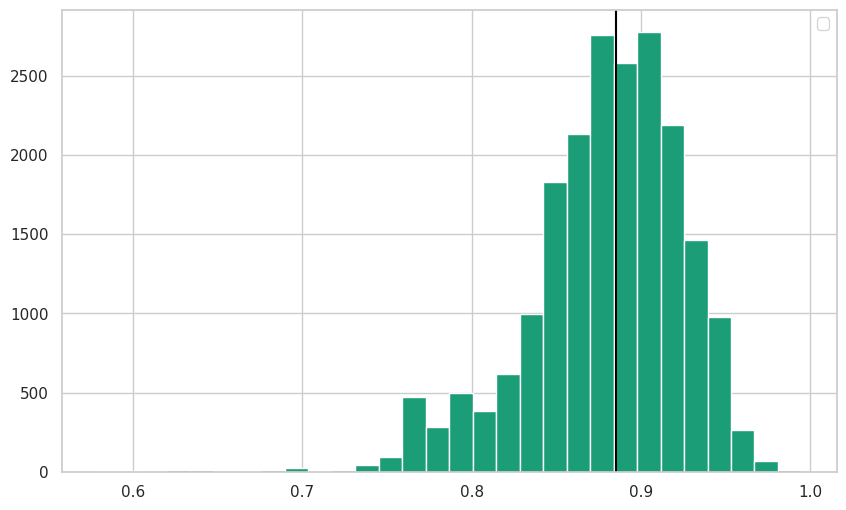

In [33]:
plt.figure(figsize=(10, 6))
plt.hist(df['desc_cont_sim_tiny_bert'], bins=30)
plt.axvline(np.median(df['desc_cont_sim_tiny_bert']), color = 'black')
plt.legend()
plt.show()

Теперь сравните распределения сходств, полученных при использовании разных подходов к векторизации.

В результате должно получиться нечто похожее на гистограмму ниже. По ней видно, что вектора Tiny BERT дают более узкий диапазон сходств. И более высокие значения. Это можно объяснить тем, что:
- модель обучалась на более широком контексте и не улавливает тонкостей разных дисциплин
- относительно стандартного BERT качество модели сильно ниже (его можно поизучать по ссылке в начале раздела)

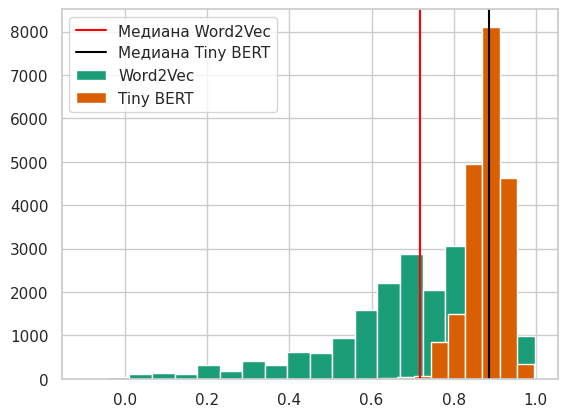

In [34]:
plt.figure()
plt.axvline(np.median(df['desc_cont_sim']), color='red', label='Медиана Word2Vec')
plt.axvline(np.median(df['desc_cont_sim_tiny_bert']), color='black', label='Медиана Tiny BERT')
plt.hist(df['desc_cont_sim'], bins=20, label='Word2Vec')
plt.hist(df['desc_cont_sim_tiny_bert'], label='Tiny BERT')
plt.legend()
plt.show()

## Задача 2 – Сгенерировать description и contents

Задача 2 – исследовательская. Надо проверить, как с работой преподавателя справится большая языковая модель. В исходных данных расположены описания и темы из содержания, написанные реальными людьми. Теперь используем LLM для той же задачи. Также рассмотрим, как разные техники промпт-инжиниринга будут влиять на результат.

### Техники промпт-инжиниринга

Под техникой промпт-инжиниринга (или промптинга) понимается практика разработки и оптимизации промптов (запросов, подсказок) к модели, которые помогут получить максимально близкий к ожидаемому ответ и эффективно взаимодействовать с языковой моделью. Это ключевой элемент в управлении работой и поведением LLM.


Наиболее популярными являются следующие техники:
1. **Zero-shot** (Обучение без примеров) – модель применяет общие знания и правила для решения новых задач.
2. **Few-shot** (Обучение на нескольких примерах) – модель адаптируется к новым задачам, используя небольшой набор примеров.
3. **Chain-of-thought** (Цепочка рассуждений) – модель генерирует пошаговое рассуждение для решения задачи, что помогает в понимании сложных задач и улучшает точность ответов.
4. **Tree of thoughts** (Дерево рассуждений) – подход, при котором рассматриваются различные варианты решений или идей, ветвящиеся от основной мысли.

В этой работе воспользуемся первыми двумя подходами.

В колабе слишком мало ресурсов (если пользоваться бесплатной версией), чтобы хотя бы запустить какую-нибудь интересную современную модель через модуль `transformers`, и тем более ресурсов не хватит для дообучения. Поэтому для тестирования воспользуемся API/serverless API.

Тестировать запросы будем к LLM mistral-nemo-instruct-2407 – https://huggingface.co/mistralai/Mistral-Nemo-Instruct-2407

Это дообученная instruct-версия модели mistral-nemo-base-2407 (12В). Модели категории Instruct способны генерировать ответ, следуя заданному им шаблону поведения.

Обе версии (base и instruct) мультиязычные и выпущены MistralAI и NVIDIA в июле 2024.

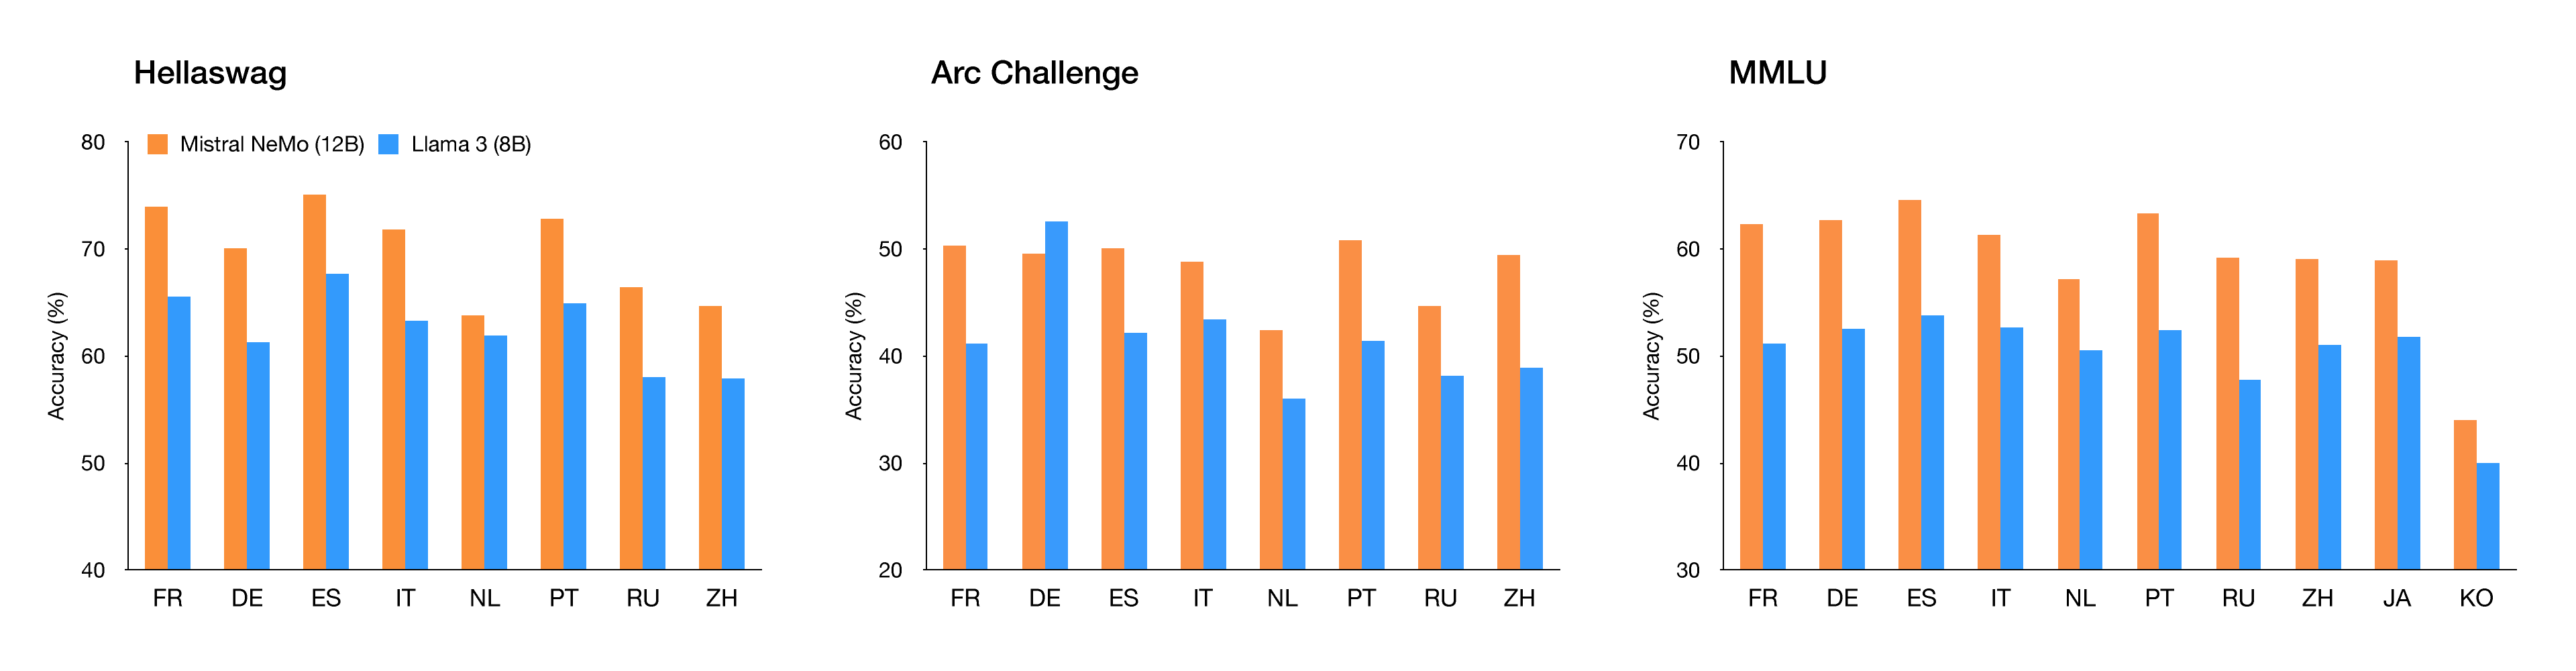

#### zero-shot

Техника промпт-инжиниринга, в которой мы, не давая модели никакой вспомогательной информации, ожидаем от нее ответа на запрос (промпт) в свободной форме.

In [35]:
from huggingface_hub import InferenceClient

client = InferenceClient(api_key="hf_XXXXXXX")  # ваш токен с  HuggingFace

Базово запустим модель через serverless API, предоставляемый HuggingFace. Это самый простой способо интегрировать модель в колаб. Для использования в реальных приложениях он не подойдет.

In [36]:
messages = [
	{
		"role": "user",
		"content": """Ты – преподаватель в университете.
                  Перечисли темы и разделы для дисциплины 'Язык Python для анализа данных'.
                  Разделов должно быть не более 8."""
	}
]

completion = client.chat.completions.create(
    model="mistralai/Mistral-Nemo-Instruct-2407",
	  messages=messages,
	  max_tokens=500
)

print(completion.choices[0].message.content)

1. Введение в язык программирования Python
2. Типы данных и переменные в Python
3. Контроль потока выполнения программы: условные операторы и циклы
4. Функции в Python
5. Из Verein: работу с файлами и országWIN
6. Регулярные выражения в Python
7. Библиотека NumPy для работы с массивами данных
8. Библиотека Pandas для манчений и анализа данных


Можно получить что-то адекватное, а можно – что-то такое🤣

>**Текст промпта имеет значение!**

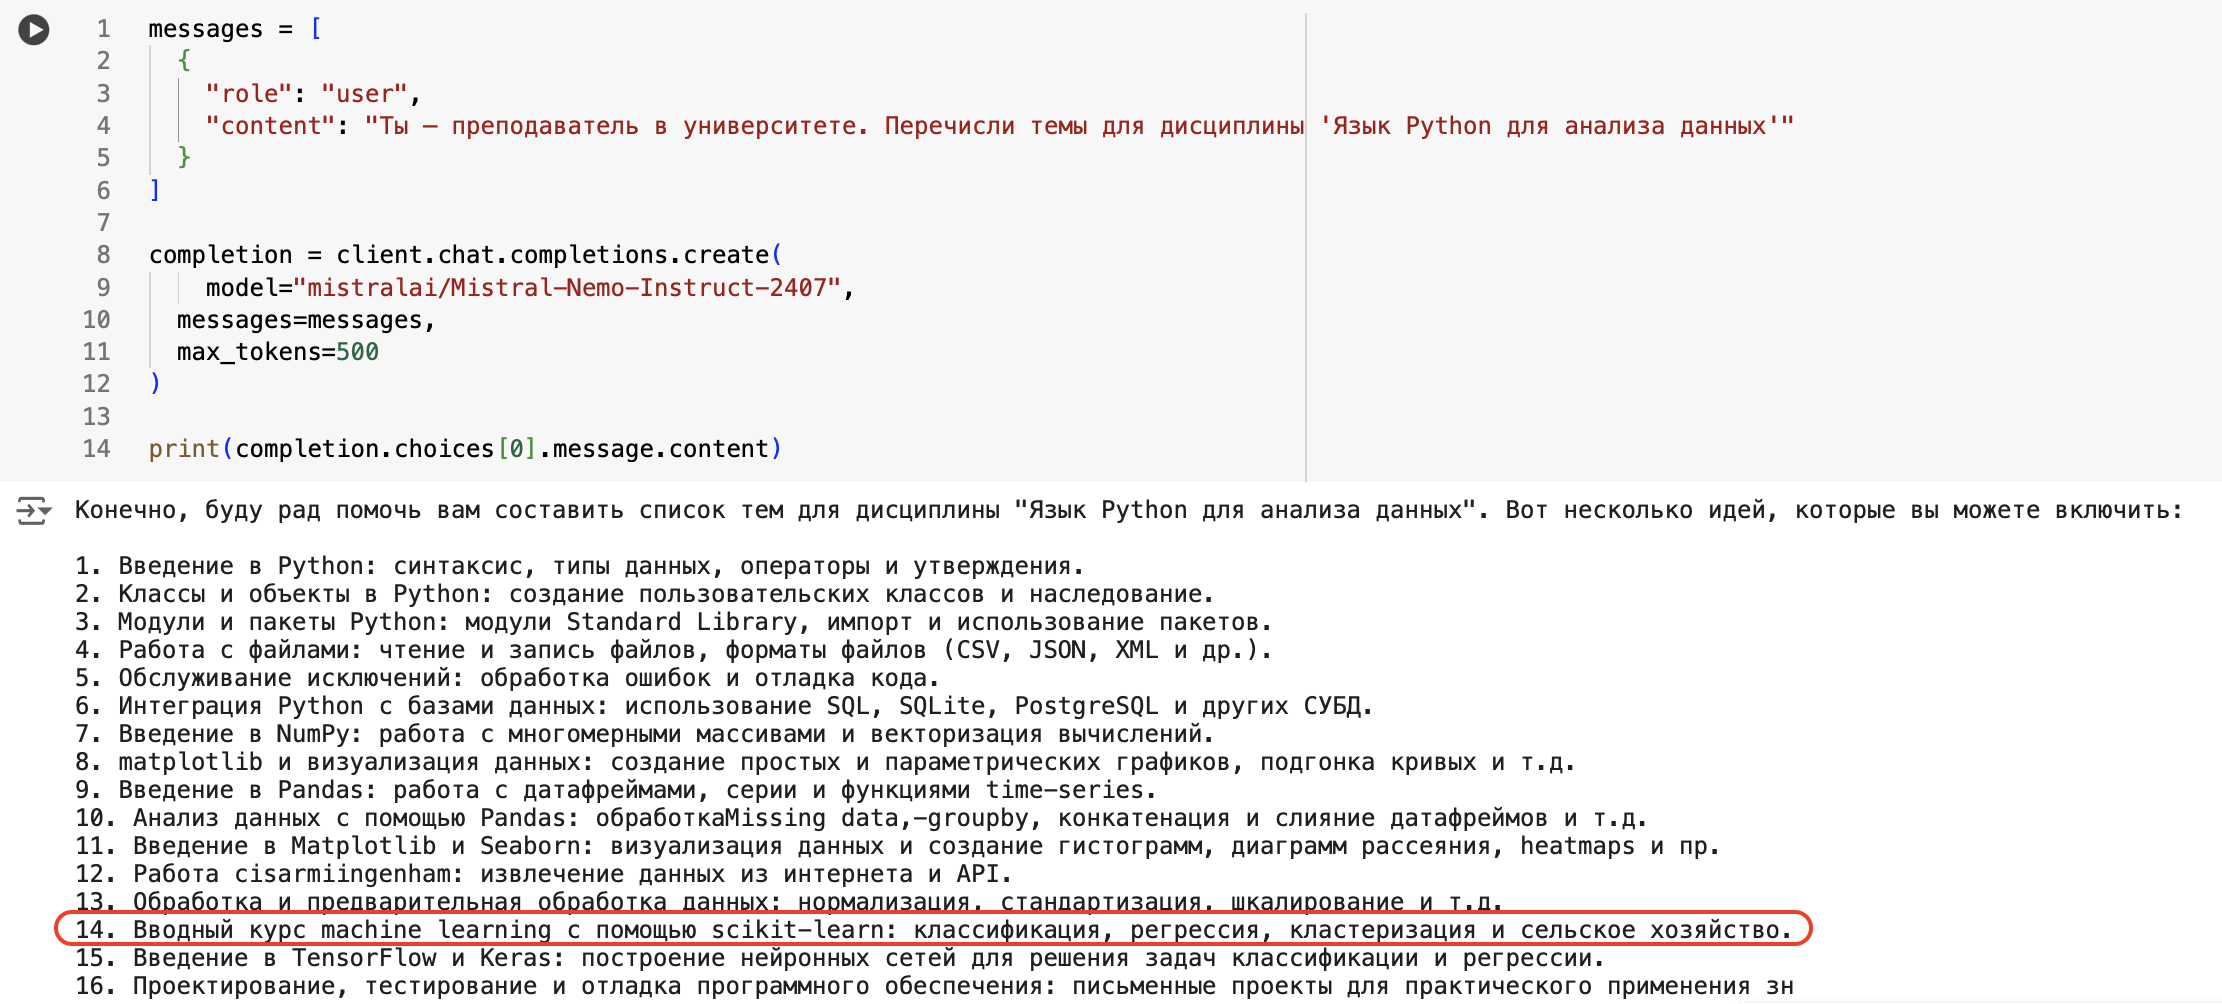

Но параметры API-запросов можно настраивать – https://huggingface.co/docs/api-inference/tasks/chat-completion

Наиболее ценные из них, сокращающие число галлюцинаций модели:
- temperature (температура): варьируется от 0 до 2 – чем выше, тем выше свобода модели в самовыражении и тем случайнее результат. До 0.5 считается низкой, но хорошо поэкспериментировать, чтобы подобрать наиболее адекватный для своей задачи результат.
- top_p – задает планку (долю), по которой отсекаются наименее релевантные ответы для вопроса, 0.1 означает, что для формирования ответа берутся 10% наиболее значимых токенов. Рекомендуется настраивать либо температуру, либо вероятность.

Поработаем с температурой. В качестве примера сгенерируем содержание дисциплины "Язык Python для анализа данных" с температурой от 0 до 2 с шагом 0.1.

In [37]:
import numpy as np

messages = [
	{
		"role": "user",
		"content": "Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины 'Язык Python для анализа данных'. Разделов должно быть не более 8."
	}
]

temperatures = np.arange(0,2,0.1)

for temp in temperatures:
    print(f"\n{'*'*20} temperature = {temp} {'*'*20}\n")

    completion = client.chat.completions.create(
        model="mistralai/Mistral-Nemo-Instruct-2407",
        messages=messages,
        max_tokens=500,
        temperature=temp
    )

    print(completion.choices[0].message.content)



******************** temperature = 0.0 ********************

1. Введение в Python: основные понятия, синтаксис, типы данных, переменные, операторы, циклы, функции.
2. Модули и пакеты: импорт модулей, работа с пакетами, виртуальные окружения.
3. Работа с файлами: чтение и запись файлов, работа с директориями, исключения при работе с файлами.
4. Коллекции данных: списки, кортежи, словари, множества, работа с коллекциями.
5. Функции высшего порядка: map, filter, reduce, lambda-функции, декораторы.
6. Объектно-ориентированное программирование: классы, объекты, наследование, полиморфизм, инкапсуляция.
7. Работа с датами и временем: модуль datetime, форматирование дат и времени.
8. Введение в NumPy и Pandas: работа с многомерными массивами, сериалами, датафреймами, визуализация данных.

******************** temperature = 0.1 ********************

1. Введение в Python: основные понятия, синтаксис, типы данных, переменные, операторы, циклы, функции.
2. Модули и пакеты: импорт модулей, работа 

Вывод: если температуру выкрутить на максимум, концентрация бреда зашкаливает, перемешиваются языки, генерируютя несуществующие слова; а если занулить, то ответ получается похожий на правду, но очень ограниченный и сухой.
>**Нужно искать такое значение температуры, при котором будет соблюдаться баланс между честностью и свободой творчества.**

В примере выше наиболее интересные результаты получились при температуре от 0.3 до 0.7. Результат на 0.7 наиболее творческий и обширный. В таком примере стоит потестировать несколько температур и повалидировать их генерации.

Попробуем еще пару примеров с другими дисциплинами.

In [38]:
import numpy as np

courses = ["Машинное обучение",
           "Современные инструменты для анализа данных",
           "Методы визуализации данных"]

messages = [
	[{
		"role": "user",
		"content": "Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины {}. Разделов должно быть не более 8.".format(course)
	}] for course in courses
]

print(messages)

# перебирать температуры выше 1 не будем, там все плохо
temperatures = np.arange(0.3,1,0.1)


for i, message in enumerate(messages):

    for temp in temperatures:
        print(f"\n{'*'*20} {courses[i]}: temperature = {temp} {'*'*20}\n")

        completion = client.chat.completions.create(
            model="mistralai/Mistral-Nemo-Instruct-2407",
            messages=message,
            max_tokens=500,
            temperature=temp
        )

        print(completion.choices[0].message.content)

[[{'role': 'user', 'content': 'Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Машинное обучение. Разделов должно быть не более 8.'}], [{'role': 'user', 'content': 'Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Современные инструменты для анализа данных. Разделов должно быть не более 8.'}], [{'role': 'user', 'content': 'Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Методы визуализации данных. Разделов должно быть не более 8.'}]]

******************** Машинное обучение: temperature = 0.3 ********************

Машинное обучение - это передовая область информатики, посвященная созданию алгоритмов и статистических моделей, которые могут обучаться и делать предсказания или принимать решения без явного программирования. В данной дисциплине можно выделить следующие темы и разделы:

1. Введение в машинное обучение
	* История и применение машинного обучения
	* Типы задач машинного обучения (классификация, регре

Здесь наиболее интересные ответы получаются при температуре 0.5–0.7. 0.7 ни в одном примере пока не ушли в откровенные галлюцинации.

Теперь сгенерируем содержание для 100 случайных дисциплин. Не будем брать все с целью экономии времени. Если есть время и желание, можно для всех 1757.

In [39]:
ud = df[["course_title"]].drop_duplicates().sample(100, random_state=42)
ud.shape

(100, 1)

Напишите функцию `mistral_zero_shot()`, которая принимает на вход название дисциплины, объект клиента и значение температуры, а возвращает содержание дисциплины.

Альтернативно промпт можно тоже сделать параметром.

In [40]:
def mistral_zero_shot(course, cli, temp):
    prompt_template = "Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины {}. Разделов должно быть не более 8."
    prompt = prompt_template.format(course)

    messages = [{
        "role": "user",
        "content": prompt
    }]

    completion = cli.chat.completions.create(
        model="mistralai/Mistral-Nemo-Instruct-2407",
        messages=messages,
        max_tokens=500,
        temperature=temp
    )

    return completion.choices[0].message.content

Добавьте столбец со сгенерированным содержанием в датафрейм.

In [41]:
generated_content =  [mistral_zero_shot(course, client, temp=0.5) for course in ud["course_title"]]


In [42]:
ud_df = df.loc[ud.index]

In [43]:
# ваш код здесь
ud_df['generated_content'] = generated_content
# пример результата после добавления столбца с генерацией
print(ud_df.shape)
ud_df.sample(3, random_state=42)

(100, 20)


,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_processed,description_processed,contents_embeddings,description_embeddings,desc_cont_sim,contents_processed_text,description_processed_text,bert_embedding_contents,bert_embedding_description,desc_cont_sim_tiny_bert,generated_content
4535,4475,Экологическое аудирование,После дисциплины обучающиеся будут знать - ме...,6917,Биотехнология,bachelor,2019,"Специализация ""Экобиотехнология""",Международный опыт экологического менеджмента ...,"[международный, опыт, экологический, менеджмен...","[дисциплина, обучающийся, быть, знать, междуна...","[-0.116298586, 0.11708449, 0.49378163, 1.11995...","[0.37696755, 0.52035403, 0.2957095, 1.2268201,...",0.878318,международный опыт экологический менеджмент ау...,дисциплина обучающийся быть знать международны...,"[0.04514328, 0.02981358, -0.0043485546, -0.038...","[0.07949328, -0.013909982, 0.020770341, -0.040...",0.914007,1. Введение в экологическое аудирование: опред...
15251,15589,Исследование альтернативных источников энергии,Цель дисципины — сформировать у обучающихся зн...,7336,Индустриальная экология / Industrial ecology,master,2021,"Специализация ""Интегрированный менеджмент""",Научные основы производства солнечной и ветрян...,"[научный, основа, производство, солнечный, вет...","[цель, дисципин, сформировывать, обучающийся, ...","[0.09321386, -0.71433204, -0.3919465, -0.05950...","[-0.010172955, -0.18676999, 0.26896128, 0.8310...",0.444719,научный основа производство солнечный ветряной...,цель дисципин сформировывать обучающийся знани...,"[0.03630762, 0.003656776, 0.0026472383, -0.022...","[-0.016435474, -0.05178493, 0.033004783, -0.03...",0.797460,1. Введение в альтернативные источники энергии...
6110,4949,Статистические методы контроля и управления,Изучение дисциплины позволит рассмотреть персп...,6942,Управление качеством,master,2020,"Специализация ""Аудит и сертификация качества""",Статистические методы контроля. Статистически...,"[статистический, метод, контроль, статистическ...","[изучение, дисциплина, позволять, рассматриват...","[0.18614689, -0.07767421, 0.32077685, 0.852021...","[0.23318672, -0.0023454975, 0.6159002, 0.92368...",0.756429,статистический метод контроль статистический м...,изучение дисциплина позволять рассматривать пе...,"[0.052147426, -0.015938062, -0.0038406083, -0....","[0.0030639062, -0.0060558254, 0.0018198256, -0...",0.878809,1. Введение в статистические методы контроля и...


Векторизуйте сгенерированное содержание с помощью обоих векторайзеров из предыдущего задания.

In [44]:
ud_df['generated_content_processed'] = ud_df['generated_content'].apply(preprocess_text)


In [45]:
ud_df['generated_content_processed_text'] = ud_df['generated_content_processed'].apply(lambda x: ' '.join(x))
ud_df['generated_content_embeddings'] = ud_df['generated_content_processed'].apply(lambda tokens: embed(tokens, w2v_model))
ud_df['bert_embedding_generated_contents'] = ud_df['generated_content_processed_text'].progress_apply(lambda x: bert_model.encode(x))

  0%|          | 0/100 [00:00<?, ?it/s]

In [46]:
# пример результата обработки
ud_df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_processed,...,contents_processed_text,description_processed_text,bert_embedding_contents,bert_embedding_description,desc_cont_sim_tiny_bert,generated_content,generated_content_processed,generated_content_processed_text,generated_content_embeddings,bert_embedding_generated_contents
4535,4475,Экологическое аудирование,После дисциплины обучающиеся будут знать - ме...,6917,Биотехнология,bachelor,2019,"Специализация ""Экобиотехнология""",Международный опыт экологического менеджмента ...,"[международный, опыт, экологический, менеджмен...",...,международный опыт экологический менеджмент ау...,дисциплина обучающийся быть знать международны...,"[0.04514328, 0.02981358, -0.0043485546, -0.038...","[0.07949328, -0.013909982, 0.020770341, -0.040...",0.914007,1. Введение в экологическое аудирование: опред...,"[введение, экологический, аудирование, определ...",введение экологический аудирование определение...,"[-0.50250494, -0.042579453, 0.2177759, 0.78916...","[0.028851248, -0.01713583, 0.03535412, -0.0049..."
15251,15589,Исследование альтернативных источников энергии,Цель дисципины — сформировать у обучающихся зн...,7336,Индустриальная экология / Industrial ecology,master,2021,"Специализация ""Интегрированный менеджмент""",Научные основы производства солнечной и ветрян...,"[научный, основа, производство, солнечный, вет...",...,научный основа производство солнечный ветряной...,цель дисципин сформировывать обучающийся знани...,"[0.03630762, 0.003656776, 0.0026472383, -0.022...","[-0.016435474, -0.05178493, 0.033004783, -0.03...",0.797460,1. Введение в альтернативные источники энергии...,"[введение, альтернативный, источник, энергия, ...",введение альтернативный источник энергия опред...,"[0.38533854, -0.32834458, -0.42649654, 0.63529...","[0.011988854, -0.009479053, 0.04329124, -0.060..."
6110,4949,Статистические методы контроля и управления,Изучение дисциплины позволит рассмотреть персп...,6942,Управление качеством,master,2020,"Специализация ""Аудит и сертификация качества""",Статистические методы контроля. Статистически...,"[статистический, метод, контроль, статистическ...",...,статистический метод контроль статистический м...,изучение дисциплина позволять рассматривать пе...,"[0.052147426, -0.015938062, -0.0038406083, -0....","[0.0030639062, -0.0060558254, 0.0018198256, -0...",0.878809,1. Введение в статистические методы контроля и...,"[введение, статистический, метод, контроль, уп...",введение статистический метод контроль управле...,"[0.07892926, -0.20311981, 0.40192708, 0.824490...","[0.016263671, -0.006345016, 0.00043485177, -0...."


Посчитайте косинусное сходство вектора исходных содержаний и сгенерированных для обоих векторайзеров.

In [47]:
# посчитаем косинусное сходство
ud_df["cont_sim_zero_shot_w2vec"] = ud_df.apply(
    lambda x: cosine_similarity(x["contents_embeddings"], x["generated_content_embeddings"]), axis=1
    )
ud_df["cont_sim_zero_shot_bert"] = ud_df.apply(
    lambda x: cosine_similarity(x["bert_embedding_contents"], x["bert_embedding_generated_contents"]), axis=1
    )

In [48]:
ud_df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_processed,...,bert_embedding_contents,bert_embedding_description,desc_cont_sim_tiny_bert,generated_content,generated_content_processed,generated_content_processed_text,generated_content_embeddings,bert_embedding_generated_contents,cont_sim_zero_shot_w2vec,cont_sim_zero_shot_bert
4535,4475,Экологическое аудирование,После дисциплины обучающиеся будут знать - ме...,6917,Биотехнология,bachelor,2019,"Специализация ""Экобиотехнология""",Международный опыт экологического менеджмента ...,"[международный, опыт, экологический, менеджмен...",...,"[0.04514328, 0.02981358, -0.0043485546, -0.038...","[0.07949328, -0.013909982, 0.020770341, -0.040...",0.914007,1. Введение в экологическое аудирование: опред...,"[введение, экологический, аудирование, определ...",введение экологический аудирование определение...,"[-0.50250494, -0.042579453, 0.2177759, 0.78916...","[0.028851248, -0.01713583, 0.03535412, -0.0049...",0.893589,0.884087
15251,15589,Исследование альтернативных источников энергии,Цель дисципины — сформировать у обучающихся зн...,7336,Индустриальная экология / Industrial ecology,master,2021,"Специализация ""Интегрированный менеджмент""",Научные основы производства солнечной и ветрян...,"[научный, основа, производство, солнечный, вет...",...,"[0.03630762, 0.003656776, 0.0026472383, -0.022...","[-0.016435474, -0.05178493, 0.033004783, -0.03...",0.797460,1. Введение в альтернативные источники энергии...,"[введение, альтернативный, источник, энергия, ...",введение альтернативный источник энергия опред...,"[0.38533854, -0.32834458, -0.42649654, 0.63529...","[0.011988854, -0.009479053, 0.04329124, -0.060...",0.743576,0.903366
6110,4949,Статистические методы контроля и управления,Изучение дисциплины позволит рассмотреть персп...,6942,Управление качеством,master,2020,"Специализация ""Аудит и сертификация качества""",Статистические методы контроля. Статистически...,"[статистический, метод, контроль, статистическ...",...,"[0.052147426, -0.015938062, -0.0038406083, -0....","[0.0030639062, -0.0060558254, 0.0018198256, -0...",0.878809,1. Введение в статистические методы контроля и...,"[введение, статистический, метод, контроль, уп...",введение статистический метод контроль управле...,"[0.07892926, -0.20311981, 0.40192708, 0.824490...","[0.016263671, -0.006345016, 0.00043485177, -0....",0.835141,0.903519



Повторите этот пайплайн для генерации краткого описания дисциплины (`description`) в технике `zero-shot`.

In [49]:
def mistral_zero_shot_description(course, cli, temp):
    prompt_template = "Ты – преподаватель в университете. Напиши краткое описание дисциплины для дисциплины {}."
    prompt = prompt_template.format(course)

    messages = [{
        "role": "user",
        "content": prompt
    }]

    completion = cli.chat.completions.create(
        model="mistralai/Mistral-Nemo-Instruct-2407",
        messages=messages,
        max_tokens=500,
        temperature=temp
    )

    return completion.choices[0].message.content

In [50]:
generated_description =  [mistral_zero_shot_description(course, client, temp=0.5) for course in ud["course_title"]]
# ваш код здесь
ud_df['generated_description'] = generated_description
# пример результата после добавления столбца с генерацией
ud_df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_processed,...,bert_embedding_description,desc_cont_sim_tiny_bert,generated_content,generated_content_processed,generated_content_processed_text,generated_content_embeddings,bert_embedding_generated_contents,cont_sim_zero_shot_w2vec,cont_sim_zero_shot_bert,generated_description
4535,4475,Экологическое аудирование,После дисциплины обучающиеся будут знать - ме...,6917,Биотехнология,bachelor,2019,"Специализация ""Экобиотехнология""",Международный опыт экологического менеджмента ...,"[международный, опыт, экологический, менеджмен...",...,"[0.07949328, -0.013909982, 0.020770341, -0.040...",0.914007,1. Введение в экологическое аудирование: опред...,"[введение, экологический, аудирование, определ...",введение экологический аудирование определение...,"[-0.50250494, -0.042579453, 0.2177759, 0.78916...","[0.028851248, -0.01713583, 0.03535412, -0.0049...",0.893589,0.884087,"Экологическое аудирование - это дисциплина, на..."
15251,15589,Исследование альтернативных источников энергии,Цель дисципины — сформировать у обучающихся зн...,7336,Индустриальная экология / Industrial ecology,master,2021,"Специализация ""Интегрированный менеджмент""",Научные основы производства солнечной и ветрян...,"[научный, основа, производство, солнечный, вет...",...,"[-0.016435474, -0.05178493, 0.033004783, -0.03...",0.797460,1. Введение в альтернативные источники энергии...,"[введение, альтернативный, источник, энергия, ...",введение альтернативный источник энергия опред...,"[0.38533854, -0.32834458, -0.42649654, 0.63529...","[0.011988854, -0.009479053, 0.04329124, -0.060...",0.743576,0.903366,Исследование альтернативных источников энергии...
6110,4949,Статистические методы контроля и управления,Изучение дисциплины позволит рассмотреть персп...,6942,Управление качеством,master,2020,"Специализация ""Аудит и сертификация качества""",Статистические методы контроля. Статистически...,"[статистический, метод, контроль, статистическ...",...,"[0.0030639062, -0.0060558254, 0.0018198256, -0...",0.878809,1. Введение в статистические методы контроля и...,"[введение, статистический, метод, контроль, уп...",введение статистический метод контроль управле...,"[0.07892926, -0.20311981, 0.40192708, 0.824490...","[0.016263671, -0.006345016, 0.00043485177, -0....",0.835141,0.903519,"Дисциплина ""Статистические методы контроля и у..."


In [51]:
ud_df['generated_description_processed'] = ud_df['generated_description'].apply(preprocess_text)
ud_df['generated_description_processed_text'] = ud_df['generated_description_processed'].apply(lambda x: ' '.join(x))
ud_df['generated_description_embeddings'] = ud_df['generated_description_processed'].apply(lambda tokens: embed(tokens, w2v_model))
ud_df['bert_embedding_generated_description'] = ud_df['generated_description_processed_text'].progress_apply(lambda x: bert_model.encode(x))

  0%|          | 0/100 [00:00<?, ?it/s]

In [52]:
# посчитаем косинусное сходство
ud_df["desc_sim_zero_shot_w2vec"] = ud_df.apply(
    lambda x: cosine_similarity(x["description_embeddings"], x["generated_description_embeddings"]), axis=1
    )
ud_df["desc_sim_zero_shot_bert"] = ud_df.apply(
    lambda x: cosine_similarity(x["bert_embedding_description"], x["bert_embedding_generated_description"]), axis=1
    )

In [53]:
ud_df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_processed,...,bert_embedding_generated_contents,cont_sim_zero_shot_w2vec,cont_sim_zero_shot_bert,generated_description,generated_description_processed,generated_description_processed_text,generated_description_embeddings,bert_embedding_generated_description,desc_sim_zero_shot_w2vec,desc_sim_zero_shot_bert
4535,4475,Экологическое аудирование,После дисциплины обучающиеся будут знать - ме...,6917,Биотехнология,bachelor,2019,"Специализация ""Экобиотехнология""",Международный опыт экологического менеджмента ...,"[международный, опыт, экологический, менеджмен...",...,"[0.028851248, -0.01713583, 0.03535412, -0.0049...",0.893589,0.884087,"Экологическое аудирование - это дисциплина, на...","[экологический, аудирование, это, дисциплина, ...",экологический аудирование это дисциплина напра...,"[-0.30802003, 0.08127863, -0.0013654454, 0.864...","[0.028056705, -0.016939431, 0.038160548, -0.03...",0.771764,0.901071
15251,15589,Исследование альтернативных источников энергии,Цель дисципины — сформировать у обучающихся зн...,7336,Индустриальная экология / Industrial ecology,master,2021,"Специализация ""Интегрированный менеджмент""",Научные основы производства солнечной и ветрян...,"[научный, основа, производство, солнечный, вет...",...,"[0.011988854, -0.009479053, 0.04329124, -0.060...",0.743576,0.903366,Исследование альтернативных источников энергии...,"[исследование, альтернативный, источник, энерг...",исследование альтернативный источник энергия э...,"[0.16488676, -0.052019082, -0.33974543, 0.4518...","[0.008748479, -0.03225746, 0.04535713, -0.0493...",0.723744,0.875365
6110,4949,Статистические методы контроля и управления,Изучение дисциплины позволит рассмотреть персп...,6942,Управление качеством,master,2020,"Специализация ""Аудит и сертификация качества""",Статистические методы контроля. Статистически...,"[статистический, метод, контроль, статистическ...",...,"[0.016263671, -0.006345016, 0.00043485177, -0....",0.835141,0.903519,"Дисциплина ""Статистические методы контроля и у...","[дисциплина, статистический, метод, контроль, ...",дисциплина статистический метод контроль управ...,"[0.15228409, -0.03454547, 0.30963528, 0.859504...","[0.039461426, -0.021953994, -0.005711229, 0.00...",0.730796,0.913521


#### few-shot

Как следует из названия техники, few-shot подразумевает, что мы даем модели несколько примеров, по которым она должна понять, в каком формате (и/или какого рода информацию) мы ожидаем получить в ответ на запрос. Эти примеры подаются как часть промпта. Можно также встретить понятия one-shot (один пример), two-shot (два примера) и т.д. Это частные случаи few-shot.

Попробуем развить предыдущий пример, используя как эталонный вариант ответа результат при температуре 0.7 для дисциплины "Язык Python для анализа данных".

In [54]:
import numpy as np

courses = ["Машинное обучение",
           "Современные инструменты для анализа данных",
           "Методы визуализации данных"]

messages = [
	[{
		"role": "user",
		"content": """Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Язык Python для анализа данных. Разделов должно быть не более 8.
Ответ:
   Тема 1: Введение в Python для анализа данных
- Обзор Python и его применения в анализе данных
- Установка и настройка Python и основных библиотек (NumPy, Pandas, Matplotlib, etc.)
- Основы синтаксиса Python

Тема 2: Основы анализа данных
- Типы данных и структуры данных в Python
- Обработка и очистка данных
- Работа с большими данными

Тема 3: Анализ данных с помощью NumPy
- Введение в NumPy
- Массивы и векторы
- Операции над массивами
- Функции и методы NumPy

Тема 4: Анализ данных с помощью Pandas
- Введение в Pandas
- Сериалы и ДатаФреймы
- Обработка и манипулирование данными
- Агрегация и групповые операции

Тема 5: Визуализация данных с помощью Matplotlib и Seaborn
- Введение в Matplotlib
- Создание простых графиков
- Настройка стиля и темы
- Введение в Seaborn

Тема 6: Статистический анализ данных
- Введение в статистический анализ
- Работа с вероятностями и распределениями
- Основные статистические тесты

Тема 7: Машинное обучение и анализ данных
- Введение в машинное обучение
- Классификация и регрессия
- Искусственные нейронные сети

Тема 8: Проекты и применение знаний
- Создание проектов по анализу данных
- Презентация результатов анализа
- Обсуждение практического применения знаний в реальных ситуациях

Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины {}. Разделов должно быть не более 8."""
.format(course)
	}] for course in courses
]

print(messages)

# перебирать температуры выше 1 не будем, там все плохо
temperatures = np.arange(0.3,0.8,0.1)


for i, message in enumerate(messages):

    for temp in temperatures:
        print(f"\n{'*'*20} {courses[i]}: temperature = {temp} {'*'*20}\n")

        completion = client.chat.completions.create(
            model="mistralai/Mistral-Nemo-Instruct-2407",
            messages=message,
            max_tokens=500,
            temperature=temp
        )

        print(completion.choices[0].message.content)

[[{'role': 'user', 'content': 'Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Язык Python для анализа данных. Разделов должно быть не более 8.\nОтвет:\n   Тема 1: Введение в Python для анализа данных\n- Обзор Python и его применения в анализе данных\n- Установка и настройка Python и основных библиотек (NumPy, Pandas, Matplotlib, etc.)\n- Основы синтаксиса Python\n\nТема 2: Основы анализа данных\n- Типы данных и структуры данных в Python\n- Обработка и очистка данных\n- Работа с большими данными\n\nТема 3: Анализ данных с помощью NumPy\n- Введение в NumPy\n- Массивы и векторы\n- Операции над массивами\n- Функции и методы NumPy\n\nТема 4: Анализ данных с помощью Pandas\n- Введение в Pandas\n- Сериалы и ДатаФреймы\n- Обработка и манипулирование данными\n- Агрегация и групповые операции\n\nТема 5: Визуализация данных с помощью Matplotlib и Seaborn\n- Введение в Matplotlib\n- Создание простых графиков\n- Настройка стиля и темы\n- Введение в Seaborn\n\nТем

Если показывать модели пример запроса и эталонный ответ, то наиболее близкие к правде ответы получаются при самых низких температурах. Возможно, ниже 0.3 было бы еще грамотнее. Зато при более высоких модели не хватает токенов и появляется много подробностей, которые, возможно, излишни.

Напишите функцию `mistral_one_shot()`, которая принимает на вход название дисциплины, объект клиента и значение температуры, а возвращает содержание дисциплины.

Аналогично предыдущему разделу, сгенерируйте содержание для выбранных 100 дисциплин (или всех). Затем предобработайте данные и проведите векторизацию обоими векторайзерами.

In [68]:
def mistral_one_shot(course, cli, temp):
    messages =[{
          "role": "user",
          "content": """Запрос: Перечисли темы и разделы для дисциплины Микромеханические чувствительные элементы.
          Ответ: Проектирование механических узлов чувствительных.
          Проектирование электромеханических узлов чувствительных элементов.
          Современные инерциальные чувствительные элементы.
          Технологические аспекты создания инерциальных чувствительных элементов.
          Проектирование механической части чувствительных элементов – инерционной массы и упругого подвеса.
          Расчет характеристик и их влияние на характеристики инерциального чувствительного элемента.
          Миниатюризация в приборостроении – введение в технологию  микромеханических чувствительных элементов (ММЧЭ).
          Назначения характеристики и расчет систем управления инерциальных чувствительных элементов.
          Проектирование и расчет датчиков углов, перемещений, моментов и силы.
          Проектирование электромеханических узлов чувствительных элементов.
          Типовые конструкции и принципы действия инерциальных  чувствительных элементов: отличия классической технологии и технологии  ММЧЭ.
          Проектирования и изготовления изделий  ММЧЭ

          Запрос: Перечисли темы и разделы для дисциплины {}.""" .format(course)
          }]


    completion = cli.chat.completions.create(
        model="mistralai/Mistral-Nemo-Instruct-2407",
        messages=message,
        max_tokens=500,
        temperature=temp
    )

    return completion.choices[0].message.content


In [73]:
generated_content_one_shot =  [mistral_one_shot(course, client, temp=0.5) for course in ud["course_title"]]
ud_df['generated_content_one_shot'] = generated_content_one_shot


In [74]:
ud_df['generated_content_processed_one_shot'] = ud_df['generated_content_one_shot'].apply(preprocess_text)
ud_df['generated_content_processed_text_one_shot'] = ud_df['generated_content_processed_one_shot'].apply(lambda x: ' '.join(x))
ud_df['generated_content_embeddings_one_shot'] = ud_df['generated_content_processed_one_shot'].apply(lambda tokens: embed(tokens, w2v_model))
ud_df['bert_embedding_generated_contents_one_shot'] = ud_df['generated_content_processed_text_one_shot'].progress_apply(lambda x: bert_model.encode(x))

  0%|          | 0/100 [00:00<?, ?it/s]

In [75]:
# посчитаем косинусное сходство
ud_df["cont_sim_one_shot_w2vec"] = ud_df.apply(
    lambda x: cosine_similarity(x["contents_embeddings"], x["generated_content_embeddings_one_shot"]), axis=1
    )
ud_df["cont_sim_one_shot_bert"] = ud_df.apply(
    lambda x: cosine_similarity(x["bert_embedding_contents"], x["bert_embedding_generated_contents_one_shot"]), axis=1
    )

In [76]:
ud_df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_processed,...,bert_embedding_generated_description,desc_sim_zero_shot_w2vec,desc_sim_zero_shot_bert,generated_content_one_shot,generated_content_processed_one_shot,generated_content_processed_text_one_shot,generated_content_embeddings_one_shot,bert_embedding_generated_contents_one_shot,cont_sim_one_shot_w2vec,cont_sim_one_shot_bert
4535,4475,Экологическое аудирование,После дисциплины обучающиеся будут знать - ме...,6917,Биотехнология,bachelor,2019,"Специализация ""Экобиотехнология""",Международный опыт экологического менеджмента ...,"[международный, опыт, экологический, менеджмен...",...,"[0.028056705, -0.016939431, 0.038160548, -0.03...",0.771764,0.901071,Тема 1: Введение в визуализацию данных\n- Знач...,"[тема, введение, визуализация, данный, значени...",тема введение визуализация данный значение виз...,"[0.61591274, 0.79464865, -0.2968796, 0.2845705...","[-0.024886595, -0.0078044888, 0.055993862, -0....",0.092052,0.712327
15251,15589,Исследование альтернативных источников энергии,Цель дисципины — сформировать у обучающихся зн...,7336,Индустриальная экология / Industrial ecology,master,2021,"Специализация ""Интегрированный менеджмент""",Научные основы производства солнечной и ветрян...,"[научный, основа, производство, солнечный, вет...",...,"[0.008748479, -0.03225746, 0.04535713, -0.0493...",0.723744,0.875365,Тема 1: Введение в визуализацию данных\n- Знач...,"[тема, введение, визуализация, данный, значени...",тема введение визуализация данный значение виз...,"[0.61591274, 0.79464865, -0.2968796, 0.2845705...","[-0.024886595, -0.0078044888, 0.055993862, -0....",-0.019591,0.696524
6110,4949,Статистические методы контроля и управления,Изучение дисциплины позволит рассмотреть персп...,6942,Управление качеством,master,2020,"Специализация ""Аудит и сертификация качества""",Статистические методы контроля. Статистически...,"[статистический, метод, контроль, статистическ...",...,"[0.039461426, -0.021953994, -0.005711229, 0.00...",0.730796,0.913521,Тема 1: Введение в визуализацию данных\n- Знач...,"[тема, введение, визуализация, данный, значени...",тема введение визуализация данный значение виз...,"[0.61591274, 0.79464865, -0.2968796, 0.2845705...","[-0.024886595, -0.0078044888, 0.055993862, -0....",0.478997,0.761252



Повторите этот пайплайн для генерации краткого описания дисциплины (`description`) в технике `few-shot`.

In [80]:
def mistral_one_shot_description(course, cli, temp):
    messages =[{
          "role": "user",
          "content": """Запрос: Напиши краткое описание для дисциплины Специальные вопросы программирования.
          Ответ: Курс направлен на получение студентами практических навыков программирования на языках C/C++
          применительно к разработке приборов и систем обработки информации в режиме реального времени.
          В рамках курса рассматриваются следующие вопросы: компиляторы и компиляция, организация памяти программ,
          особенности языков C/C++, оптимизация программ по производительности и объему памяти, методы “безопасного”
          кодирования, применение С в микроконтроллерах, концепции ООП в C++, взаимодействие с внешними устройствами,
          визуализация данных и т.д.

          Запрос: Напиши краткое описание для дисциплины {}.""" .format(course)
          }]


    completion = cli.chat.completions.create(
        model="mistralai/Mistral-Nemo-Instruct-2407",
        messages=message,
        max_tokens=500,
        temperature=temp
    )

    return completion.choices[0].message.content


In [81]:
generated_description_one_shot =  [mistral_one_shot_description(course, client, temp=0.5) for course in ud["course_title"]]
ud_df['generated_description_one_shot'] = generated_description_one_shot


In [82]:
ud_df['generated_description_processed_one_shot'] = ud_df['generated_description_one_shot'].apply(preprocess_text)
ud_df['generated_description_processed_text_one_shot'] = ud_df['generated_description_processed_one_shot'].apply(lambda x: ' '.join(x))
ud_df['generated_description_embeddings_one_shot'] = ud_df['generated_description_processed_one_shot'].apply(lambda tokens: embed(tokens, w2v_model))
ud_df['bert_embedding_generated_description_one_shot'] = ud_df['generated_description_processed_text_one_shot'].progress_apply(lambda x: bert_model.encode(x))

  0%|          | 0/100 [00:00<?, ?it/s]

In [83]:
# посчитаем косинусное сходство
ud_df["desc_sim_one_shot_w2vec"] = ud_df.apply(
    lambda x: cosine_similarity(x["contents_embeddings"], x["generated_description_embeddings_one_shot"]), axis=1
    )
ud_df["desc_sim_one_shot_bert"] = ud_df.apply(
    lambda x: cosine_similarity(x["bert_embedding_contents"], x["bert_embedding_generated_description_one_shot"]), axis=1
    )

In [84]:
ud_df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_processed,...,bert_embedding_generated_contents_one_shot,cont_sim_one_shot_w2vec,cont_sim_one_shot_bert,generated_description_one_shot,generated_description_processed_one_shot,generated_description_processed_text_one_shot,generated_description_embeddings_one_shot,bert_embedding_generated_description_one_shot,desc_sim_one_shot_w2vec,desc_sim_one_shot_bert
4535,4475,Экологическое аудирование,После дисциплины обучающиеся будут знать - ме...,6917,Биотехнология,bachelor,2019,"Специализация ""Экобиотехнология""",Международный опыт экологического менеджмента ...,"[международный, опыт, экологический, менеджмен...",...,"[-0.024886595, -0.0078044888, 0.055993862, -0....",0.092052,0.712327,Тема 1: Введение в визуализацию данных\n- Знач...,"[тема, введение, визуализация, данный, значени...",тема введение визуализация данный значение виз...,"[0.61591274, 0.79464865, -0.2968796, 0.2845705...","[-0.024886595, -0.0078044888, 0.055993862, -0....",0.092052,0.712327
15251,15589,Исследование альтернативных источников энергии,Цель дисципины — сформировать у обучающихся зн...,7336,Индустриальная экология / Industrial ecology,master,2021,"Специализация ""Интегрированный менеджмент""",Научные основы производства солнечной и ветрян...,"[научный, основа, производство, солнечный, вет...",...,"[-0.024886595, -0.0078044888, 0.055993862, -0....",-0.019591,0.696524,Тема 1: Введение в визуализацию данных\n- Знач...,"[тема, введение, визуализация, данный, значени...",тема введение визуализация данный значение виз...,"[0.61591274, 0.79464865, -0.2968796, 0.2845705...","[-0.024886595, -0.0078044888, 0.055993862, -0....",-0.019591,0.696524
6110,4949,Статистические методы контроля и управления,Изучение дисциплины позволит рассмотреть персп...,6942,Управление качеством,master,2020,"Специализация ""Аудит и сертификация качества""",Статистические методы контроля. Статистически...,"[статистический, метод, контроль, статистическ...",...,"[-0.024886595, -0.0078044888, 0.055993862, -0....",0.478997,0.761252,Тема 1: Введение в визуализацию данных\n- Знач...,"[тема, введение, визуализация, данный, значени...",тема введение визуализация данный значение виз...,"[0.61591274, 0.79464865, -0.2968796, 0.2845705...","[-0.024886595, -0.0078044888, 0.055993862, -0....",0.478997,0.761252


In [85]:
ud_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 9916 to 3902
Data columns (total 47 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   course_id                                      100 non-null    int64  
 1   course_title                                   100 non-null    object 
 2   description                                    100 non-null    object 
 3   up_id                                          100 non-null    int64  
 4   up_title                                       100 non-null    object 
 5   qualification                                  100 non-null    object 
 6   start_year                                     100 non-null    int64  
 7   module_name                                    100 non-null    object 
 8   contents                                       100 non-null    object 
 9   contents_processed                             100 non-

## Задача 3 – Проанализировать результаты

Постройте визуализации для оценки результатов генерации искусственных данных по дисциплинам. В каждом пункте оценивайте результаты генерации в обеих техниках. Для каждого пункта напишите краткий вывод.

1. Постройте гистограмму, показывающую распределения сходств краткого описания с эталонным (человеческим) и содержания. Сравните результаты для обоих векторайзеров.

In [103]:
def plot_similarity_with_median(similarity_data, title, color):
    plt.figure(figsize=(8, 5))
    sns.histplot(similarity_data, bins=20, kde=True, color=color)

    median_value = similarity_data.median()
    plt.axvline(median_value, color="red", linestyle="--", label=f"Медиана: {median_value:.2f}")

    plt.title(title, fontsize=14)
    plt.xlabel("Сходство", fontsize=12)
    plt.ylabel("Частота", fontsize=12)
    plt.legend()
    plt.show()


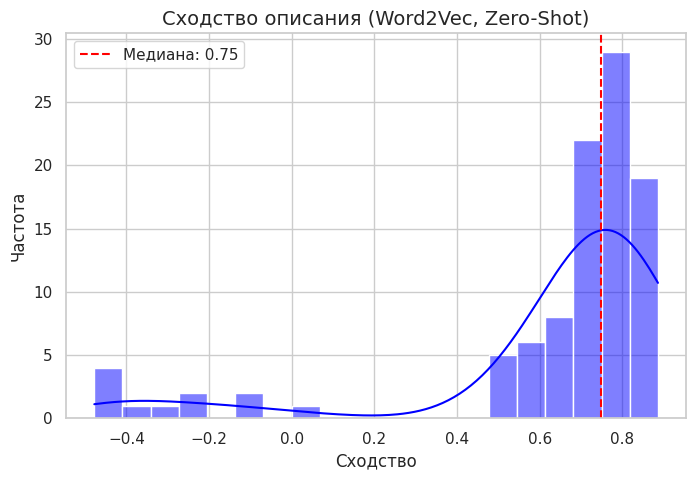

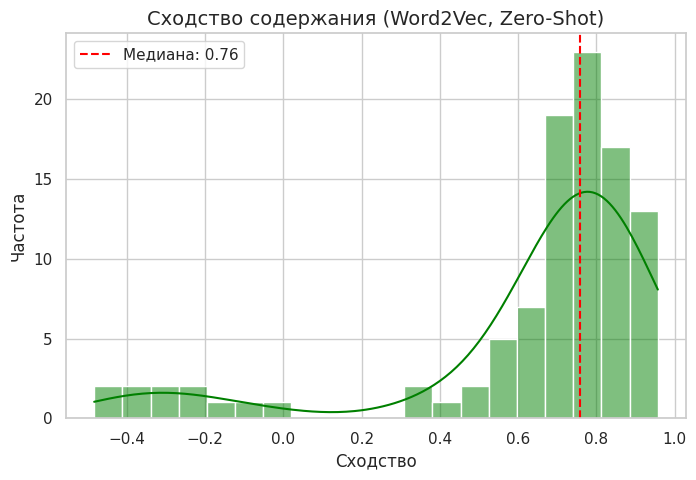

In [104]:
# Краткое описание
plot_similarity_with_median(
    ud_df["desc_sim_zero_shot_w2vec"],
    "Сходство описания (Word2Vec, Zero-Shot)",
    "blue"
)

# Содержание
plot_similarity_with_median(
    ud_df["cont_sim_zero_shot_w2vec"],
    "Сходство содержания (Word2Vec, Zero-Shot)",
    "green"
)


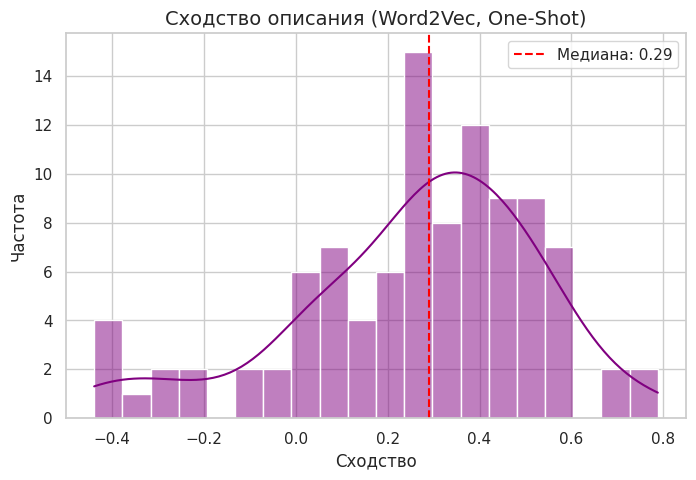

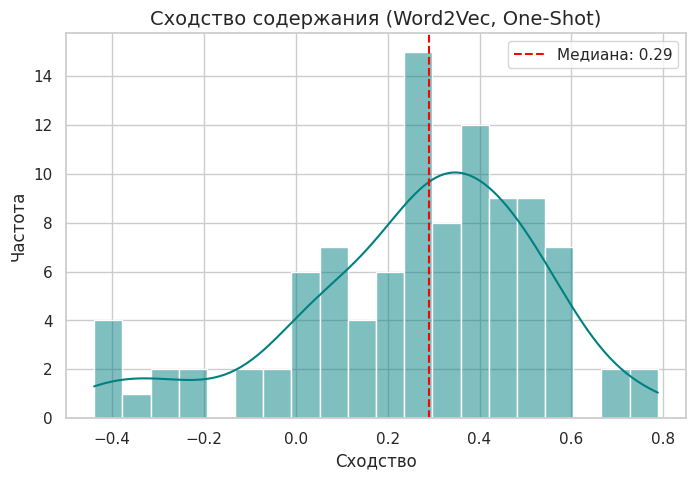

In [105]:
# Краткое описание
plot_similarity_with_median(
    ud_df["desc_sim_one_shot_w2vec"],
    "Сходство описания (Word2Vec, One-Shot)",
    "purple"
)

# Содержание
plot_similarity_with_median(
    ud_df["cont_sim_one_shot_w2vec"],
    "Сходство содержания (Word2Vec, One-Shot)",
    "teal"
)

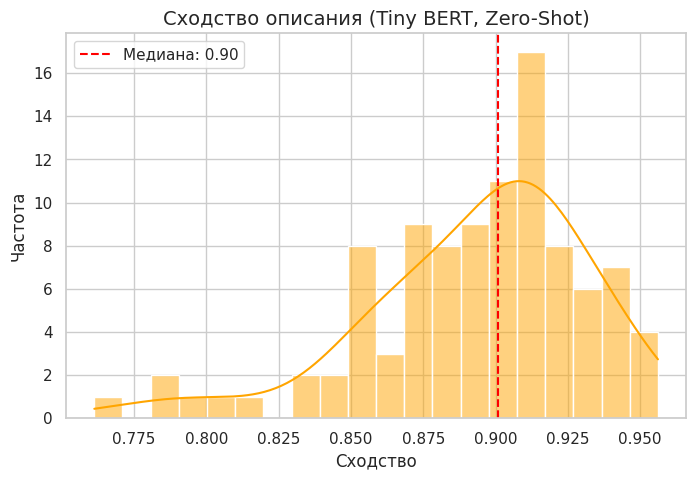

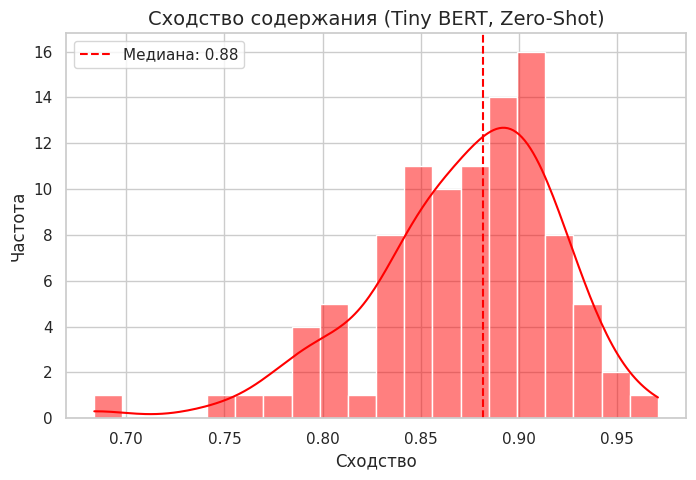

In [108]:
# Краткое описание
plot_similarity_with_median(
    ud_df["desc_sim_zero_shot_bert"],
    "Сходство описания (Tiny BERT, Zero-Shot)",
    "orange"
)

# Содержание
plot_similarity_with_median(
    ud_df["cont_sim_zero_shot_bert"],
    "Сходство содержания (Tiny BERT, Zero-Shot)",
    "red"
)


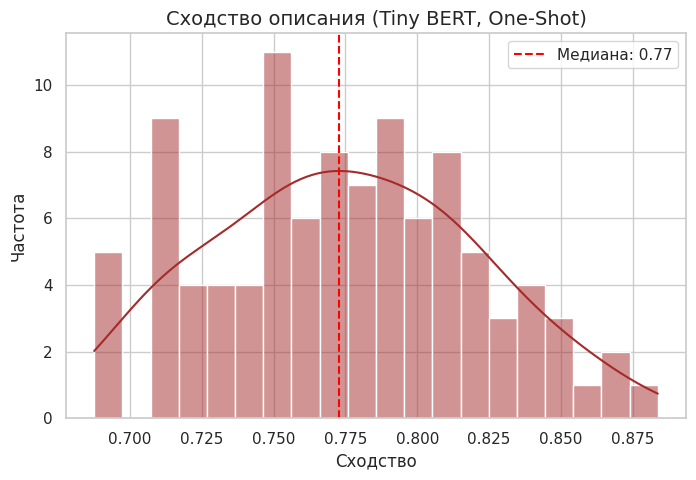

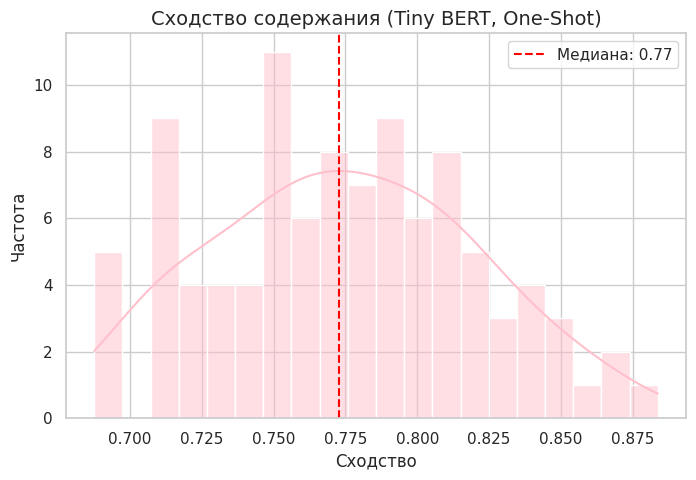

In [109]:
# Краткое описание
plot_similarity_with_median(
    ud_df["desc_sim_one_shot_bert"],
    "Сходство описания (Tiny BERT, One-Shot)",
    "brown"
)

# Содержание
plot_similarity_with_median(
    ud_df["cont_sim_one_shot_bert"],
    "Сходство содержания (Tiny BERT, One-Shot)",
    "pink"
)


Так как медиана косинусного сходства выше у zero-shot для обоих векторизаторов, обучение без примеров больше подходит для задачи генерации содержания и описания для данного датасета.

Более подходящим векторизатором является Tiny Bert, так как он не показывает отрицательных выбросов, которые есть у word2vec

2. Оцените среднее косинусное сходство содержания и краткого описания, сгенерированных человеком и языковой моделью, в разрезе по уровням образования (`qualification`). Сравните результаты для обоих векторайзеров.

In [111]:
grouped_ud_df = ud_df.groupby("qualification").agg({
    "desc_sim_zero_shot_w2vec": "mean",
    "desc_sim_zero_shot_bert": "mean",
    "desc_sim_one_shot_w2vec": "mean",
    "desc_sim_one_shot_bert": "mean",
    "cont_sim_zero_shot_w2vec": "mean",
    "cont_sim_zero_shot_bert": "mean",
    "cont_sim_one_shot_w2vec": "mean",
    "cont_sim_one_shot_bert": "mean"
}).reset_index()

grouped_ud_df


,qualification,desc_sim_zero_shot_w2vec,desc_sim_zero_shot_bert,desc_sim_one_shot_w2vec,desc_sim_one_shot_bert,cont_sim_zero_shot_w2vec,cont_sim_zero_shot_bert,cont_sim_one_shot_w2vec,cont_sim_one_shot_bert
0,bachelor,0.720771,0.902144,0.279432,0.776093,0.745277,0.883351,0.279432,0.776093
1,master,0.510736,0.881615,0.235137,0.772330,0.493628,0.855568,0.235137,0.772330


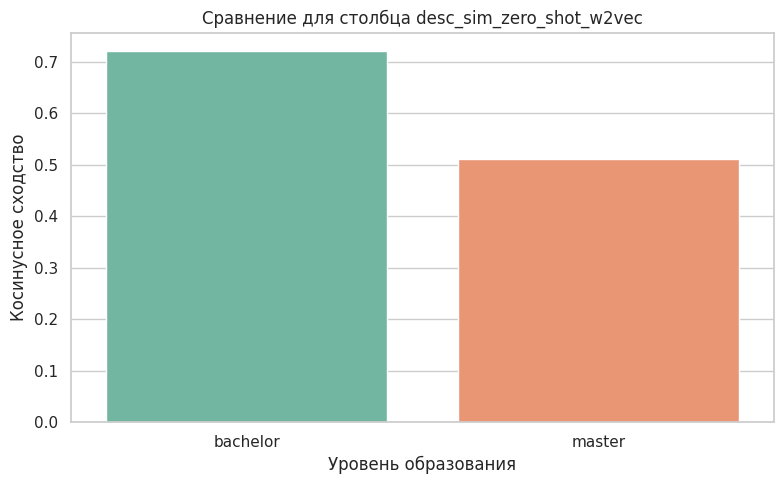

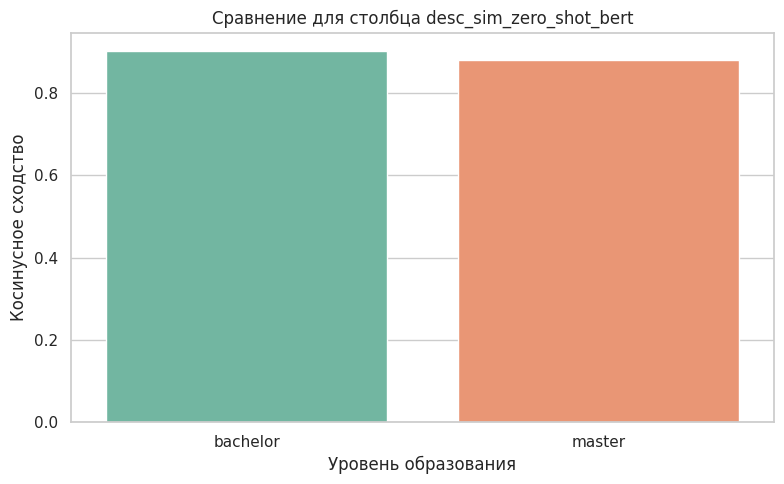

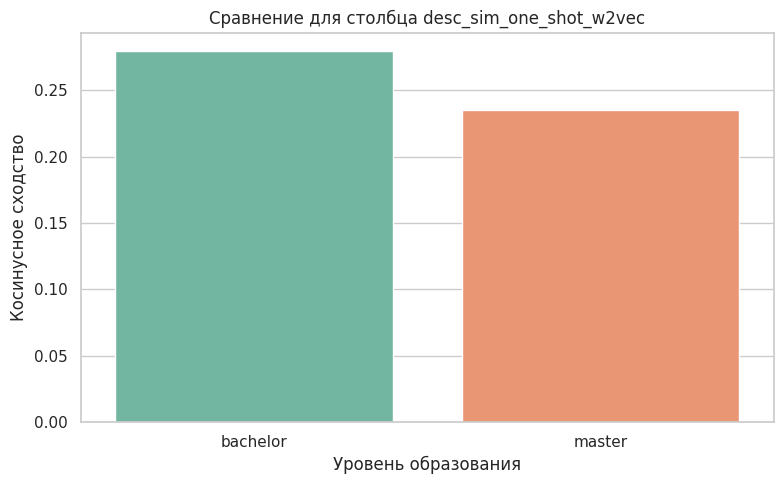

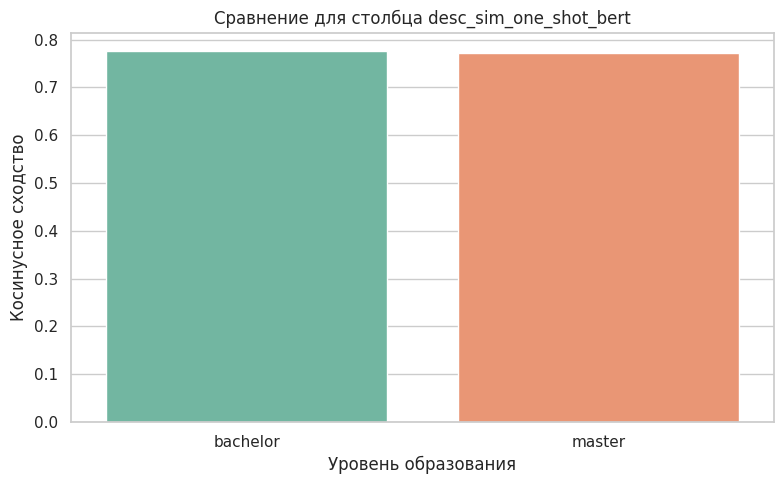

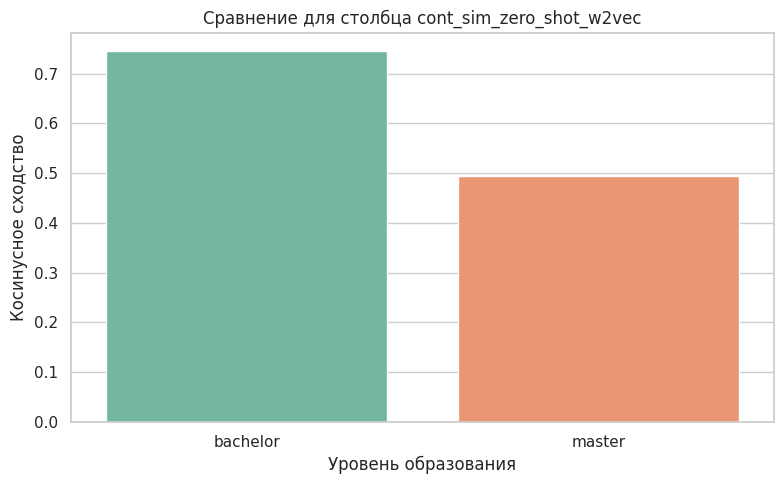

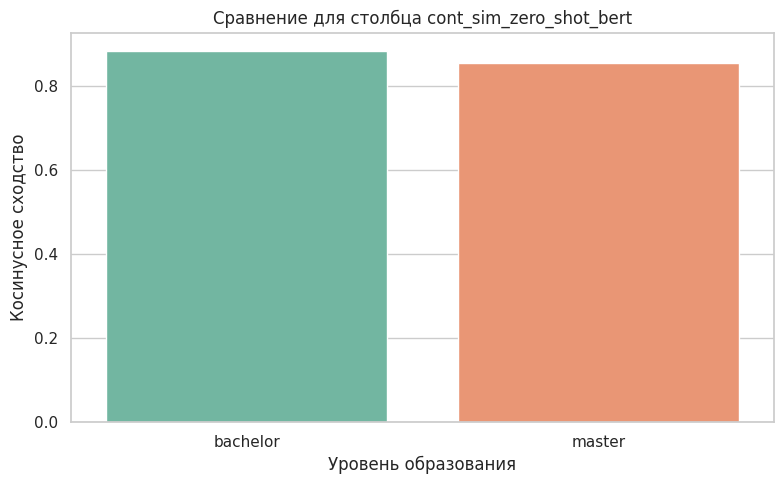

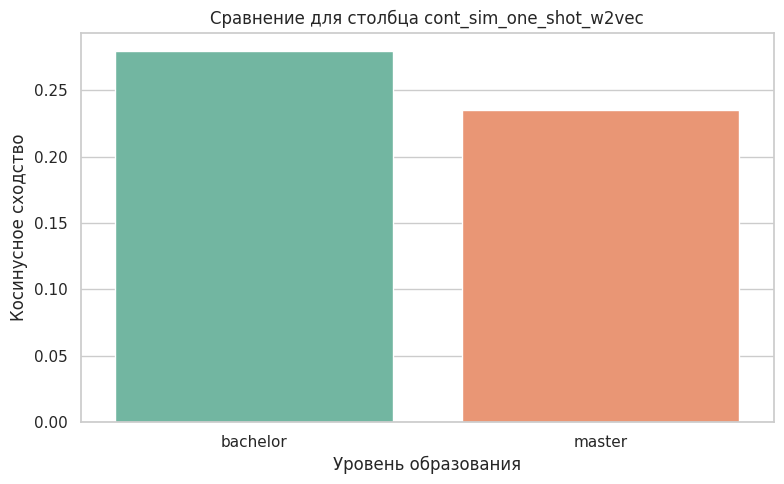

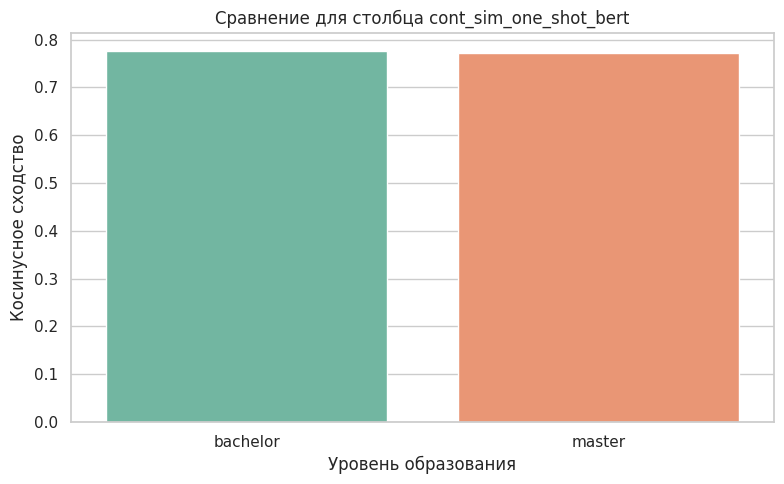

In [133]:
def plot_comparisons_for_each_column(df):
    cols = list(df.columns)
    cols.pop(0)

    for column in cols:
        plt.figure(figsize=(8, 5))

        sns.barplot(x="qualification", y=column, hue="qualification", data=df, palette="Set2")

        plt.title(f'Сравнение для столбца {column}')
        plt.xlabel('Уровень образования')
        plt.ylabel('Косинусное сходство')

        plt.tight_layout()
        plt.show()

plot_comparisons_for_each_column(grouped_ud_df)

В среднее косинусное сходство описаний и содержаний для бакалавров в среднем больше чем для магистрантров. Получается что лучше сгенерированы описания и содержания для программ бакалавриата.

3. Оцените среднее косинусное сходство содержания и краткого описания, сгенерированных человеком и языковой моделью, в разрезе по году (`start_year`). Сравните результаты для обоих векторайзеров.

In [136]:
grouped_start_year = ud_df.groupby('start_year').agg({
    "desc_sim_zero_shot_w2vec": "mean",
    "desc_sim_zero_shot_bert": "mean",
    "desc_sim_one_shot_w2vec": "mean",
    "desc_sim_one_shot_bert": "mean",
    "cont_sim_zero_shot_w2vec": "mean",
    "cont_sim_zero_shot_bert": "mean",
    "cont_sim_one_shot_w2vec": "mean",
    "cont_sim_one_shot_bert": "mean"
}).reset_index()
desc_columns = [
    'desc_sim_zero_shot_w2vec', 'desc_sim_zero_shot_bert',
    'desc_sim_one_shot_w2vec', 'desc_sim_one_shot_bert'
]
cont_columns = [
    'cont_sim_zero_shot_w2vec', 'cont_sim_zero_shot_bert',
    'cont_sim_one_shot_w2vec', 'cont_sim_one_shot_bert'
]


In [138]:
grouped_start_year

,start_year,desc_sim_zero_shot_w2vec,desc_sim_zero_shot_bert,desc_sim_one_shot_w2vec,desc_sim_one_shot_bert,cont_sim_zero_shot_w2vec,cont_sim_zero_shot_bert,cont_sim_one_shot_w2vec,cont_sim_one_shot_bert
0,2018,0.720546,0.902863,0.411276,0.812152,0.724462,0.884268,0.411276,0.812152
1,2019,0.720177,0.898757,0.246683,0.761342,0.759414,0.877321,0.246683,0.761342
2,2020,0.735407,0.908066,0.308032,0.786487,0.713213,0.886031,0.308032,0.786487
3,2021,0.411308,0.869546,0.156288,0.757683,0.415111,0.844200,0.156288,0.757683
4,2022,0.450397,0.879082,0.219698,0.766921,0.473360,0.867246,0.219698,0.766921


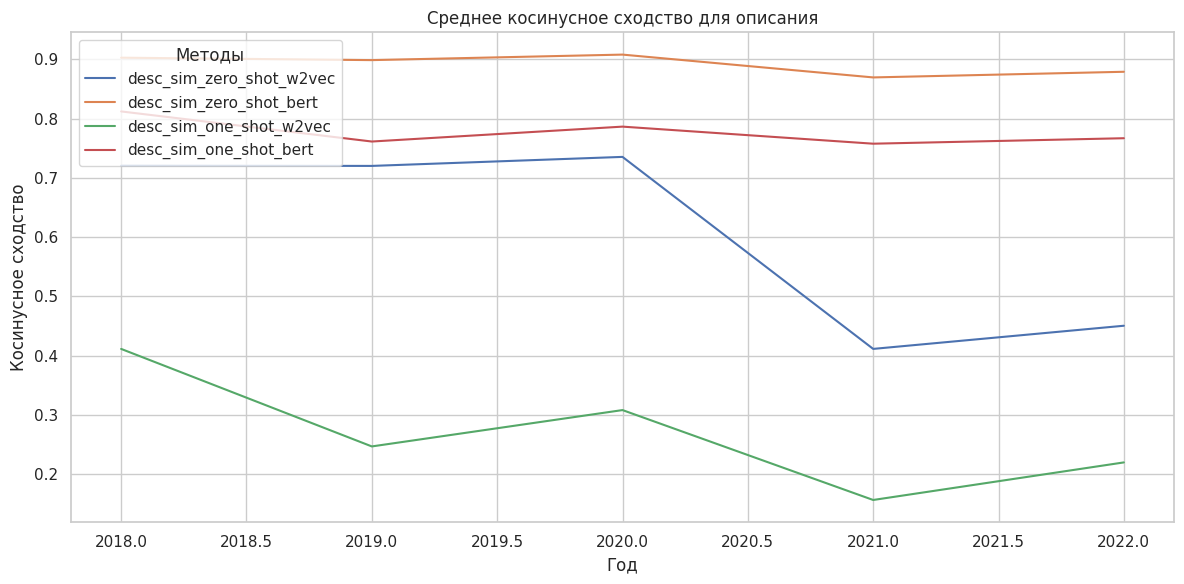

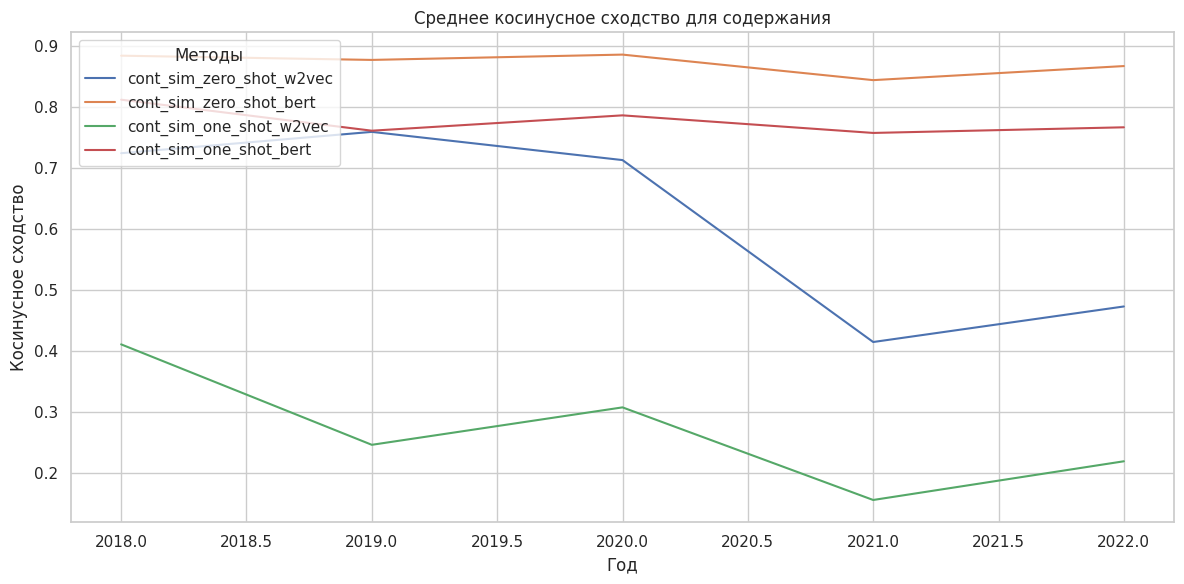

In [141]:

def plot_cosine_similarity_year(grouped_data, columns, title, ylabel='Косинусное сходство'):
    plt.figure(figsize=(12, 6))
    for col in columns:
        sns.lineplot(x='start_year', y=col, data=grouped_data, label=col)

    plt.title(title)
    plt.xlabel('Год')
    plt.ylabel(ylabel)
    plt.legend(title='Методы', loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Строим графики для описаний и содержимого с помощью w2v
plot_cosine_similarity_year(grouped_start_year, desc_columns, 'Среднее косинусное сходство для описания')
plot_cosine_similarity_year(grouped_start_year, cont_columns, 'Среднее косинусное сходство для содержания')

Среднее косинусное сходство на обоих графиках при использовании векторайзера w2vec сильно падает в 2021. При использовании векторайзера Tiny Bert разница в среднем косинусном сходстве на протяжении 2018-2022 небольшая, то есть он более стабильный

4. Оцените среднее косинусное сходство содержания и краткого описания, сгенерированных человеком и языковой моделью, в разрезе по уровням образования и годам, но только с помощью векторов  w2v.

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

columns= [
    'desc_sim_zero_shot_w2vec', 'desc_sim_one_shot_w2vec',
    'cont_sim_zero_shot_w2vec', 'cont_sim_one_shot_w2vec'
]

grouped_year_qual = ud_df.groupby(['qualification', 'start_year']).agg({
    "desc_sim_zero_shot_w2vec": "mean",
    "desc_sim_one_shot_w2vec": "mean",
    "cont_sim_zero_shot_w2vec": "mean",
    "cont_sim_one_shot_w2vec": "mean",
}).reset_index()


grouped_year_qual


,qualification,start_year,desc_sim_zero_shot_w2vec,desc_sim_one_shot_w2vec,cont_sim_zero_shot_w2vec,cont_sim_one_shot_w2vec
0,bachelor,2018,0.720546,0.411276,0.724462,0.411276
1,bachelor,2019,0.720177,0.246683,0.759414,0.246683
2,bachelor,2020,0.721389,0.194500,0.727150,0.194500
3,bachelor,2021,0.686724,0.444129,0.773846,0.444129
4,bachelor,2022,0.760291,0.251905,0.778987,0.251905
5,master,2020,0.746796,0.400276,0.701889,0.400276
6,master,2021,0.389275,0.133260,0.386412,0.133260
7,master,2022,0.140504,0.187490,0.167734,0.187490


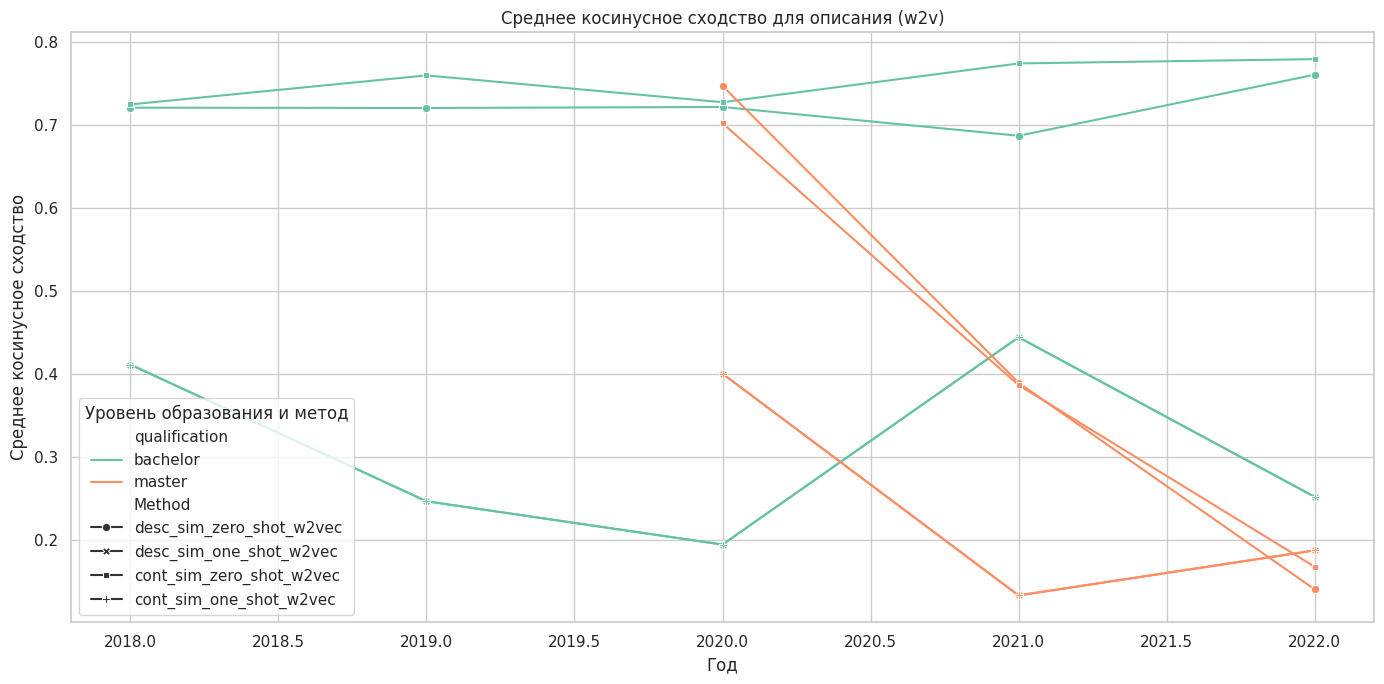

In [150]:

def plot_cosine_similarity_qual_year(data, columns, title):
    data_melted = data.melt(id_vars=['qualification', 'start_year'], value_vars=columns,
                            var_name='Method', value_name='Cosine Similarity')

    plt.figure(figsize=(14, 7))
    sns.lineplot(data=data_melted, x='start_year', y='Cosine Similarity', hue='qualification',
                 style='Method', markers=True, dashes=False, palette='Set2')
    plt.title(title)
    plt.xlabel('Год')
    plt.ylabel('Среднее косинусное сходство')
    plt.legend(title='Уровень образования и метод')
    plt.tight_layout()
    plt.show()

# Отрисовываем графики
plot_cosine_similarity_qual_year(grouped_year_qual, columns, 'Среднее косинусное сходство для описания (w2v)')


Для магистратуры значения среднего косинусного сходства сильно варьируются, есть сильное падение 2021 году у обеих техник генерации. Максимальное значение среднего косинусного сходства для магистратуры обеими техниками генерации достигается в 2020.





5. Оцените средние значения сходства эталонных данных и генераций обеими техниками в разрезе по уровню образования (`qualification`). То есть постройте такую диграмму, по которой будет видно, для какого уровня образования какая из техник в среднем дает более близкий к эталонному контекст.

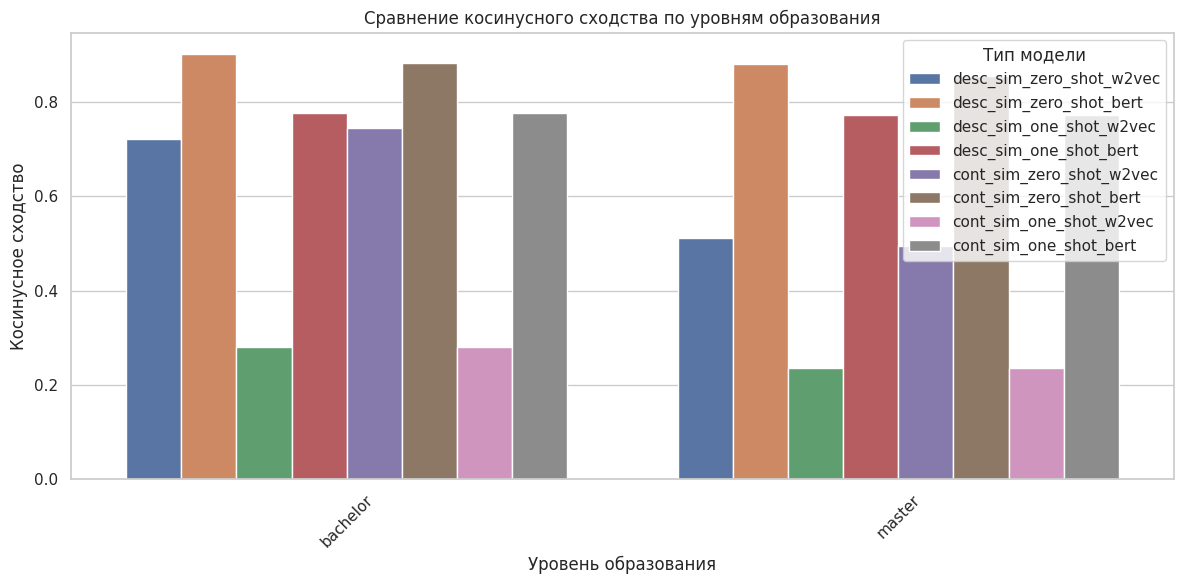

In [119]:

def plot_similarity_comparison(df):
    df_melted = df.melt(id_vars="qualification", var_name="model_type", value_name="similarity")

    plt.figure(figsize=(12, 6))

    sns.barplot(x="qualification", y="similarity", hue="model_type", data=df_melted)

    plt.title('Сравнение косинусного сходства по уровням образования')
    plt.xlabel('Уровень образования')
    plt.ylabel('Косинусное сходство')
    plt.xticks(rotation=45)
    plt.legend(title='Тип модели')

    plt.tight_layout()
    plt.show()


plot_similarity_comparison(grouped_ud_df)

Для обоих уровней образования и для генерации обоих столбцов (содержания и описания) наибольшее среднее косинусное сходство достигается про комбинации zero-shot и Tiny Bert

## Куда сдавать?

По инструкции в гитхаб – https://shy-question-39d.notion.site/1150ea832e418032bfc3d3e827c380fb?pvs=74

- К этой работе тестов нет.
- Эту работу можно выполнить с кем-нибудь в паре или в гордом одиночестве.
- Пул-реквест нужно сделать в ветку `lab4`. Если вас двое, то можно 1 или 2 пул-реквеста, главное – отметьте как-нибудь, что выполняли в паре.

**Устная защита работ не требуется, но вам могут быть заданы вопросы прямо в вашем пул-реквесте!**